# Propagation of Disease-Demographic Co-occurrences to Model Logits


## Set up

**Just run this part**


### Paths and Dictionaries


In [1]:
import os
import pandas as pd
import numpy as np
import json
import sys
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import kendalltau, rankdata
import rbo
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
project_root_relative_path = "../.."  # Adjust this path as necessary

# Use os.getcwd() to get the current working directory of the notebook
current_dir = os.getcwd()

# Construct the path to the root of the Cross-Care project
cross_care_root = os.path.normpath(
    os.path.join(current_dir, project_root_relative_path)
)

# Add the Cross-Care root to sys.path to allow imports
if cross_care_root not in sys.path:
    sys.path.append(cross_care_root)

print("Project root added to sys.path:", cross_care_root)

from dicts.dict_medical import medical_keywords_dict

Project root added to sys.path: /home/shan/Desktop/netlab/github/Cross-Care


In [3]:
race_categories = [
    "pacific islander",
    "hispanic",
    "asian",
    "indigenous",
    "white",
    "black",
]
gender_categories = [
    "male",
    "female",
    "nonbinary",
]
census_ratio = {
    "white": 61.6,
    "black": 12.6,
    "indigenous": 1.1,
    "asian": 6,
    "pacific islander": 0.2,
    "hispanic": 16.3,
}

In [4]:
models = [
    "EleutherAI/pythia-70m-deduped",
    "EleutherAI/pythia-160m-deduped",
    "EleutherAI/pythia-410m-deduped",
    "EleutherAI/pythia-1b-deduped",
    "EleutherAI/pythia-2.8b-deduped",
    "EleutherAI/pythia-6.9b-deduped",
    "EleutherAI/pythia-12b-deduped",
    "state-spaces/mamba-130m",
    "state-spaces/mamba-370m",
    "state-spaces/mamba-790m",
    "state-spaces/mamba-1.4b",
    "state-spaces/mamba-2.8b-slimpj",
    # "state-spaces/mamba-2.8b"
]

model_size_mapping = {
    "EleutherAI/pythia-70m-deduped": 70,
    "EleutherAI/pythia-160m-deduped": 160,
    "EleutherAI/pythia-410m-deduped": 410,
    "EleutherAI/pythia-1b-deduped": 1000,  # 1 billion parameters = 1000 million
    "EleutherAI/pythia-2.8b-deduped": 2800,  # 2.8 billion parameters = 2800 million
    "EleutherAI/pythia-6.9b-deduped": 6900,  # 6.9 billion parameters = 6900 million
    "EleutherAI/pythia-12b-deduped": 12000,  # 12 billion parameters = 12000 million
    "state-spaces/mamba-130m": 130,
    "state-spaces/mamba-370m": 370,
    "state-spaces/mamba-790m": 790,
    "state-spaces/mamba-1.4b": 1400,
    "state-spaces/mamba-2.8b-slimpj": 2800,
    "state-spaces/mamba-2.8b": 2800,
}

### Load and Preprocessing


In [5]:
def calculate_deciles(df, column_name, decile_column_name):
    # Calculate deciles (1=lowest, 10=highest). Use 'duplicates="drop"' to handle bins with the same edges.
    df[decile_column_name] = (
        pd.qcut(df[column_name], 10, labels=False, duplicates="drop") + 1
    )

### Ranking


In [6]:
# Define a function to extract the required lists for a given model
def extract_demographics_lists_for_model(df, model_name):
    # Filter the dataframe for the specified model
    model_df = df[df["model_name"] == model_name]

    # Initialize lists to store the results
    max_logit_demographics = []
    min_logit_demographics = []
    max_mentions_demographics = []
    min_mentions_demographics = []

    # Get a list of unique diseases to fix the order
    diseases = model_df["disease"].unique()

    for disease in diseases:
        disease_df = model_df[model_df["disease"] == disease]

        # Max and Min logit demographics
        max_logit_demographic = disease_df.loc[
            disease_df["logit_value"].idxmax(), "demographic"
        ]
        min_logit_demographic = disease_df.loc[
            disease_df["logit_value"].idxmin(), "demographic"
        ]

        # Max and Min mention count demographics
        max_mentions_demographic = disease_df.loc[
            disease_df["mention_count"].idxmax(), "demographic"
        ]
        min_mentions_demographic = disease_df.loc[
            disease_df["mention_count"].idxmin(), "demographic"
        ]

        # Append to lists
        max_logit_demographics.append(max_logit_demographic)
        min_logit_demographics.append(min_logit_demographic)
        max_mentions_demographics.append(max_mentions_demographic)
        min_mentions_demographics.append(min_mentions_demographic)

    return (
        max_logit_demographics,
        min_logit_demographics,
        max_mentions_demographics,
        min_mentions_demographics,
    )


def count_demographics(demographics_list):
    # Count the occurrence of each demographic in the list
    return pd.Series(demographics_list).value_counts().to_dict()

In [7]:
def calculate_ranks(values):
    return rankdata(-values, method="ordinal")  # Negative for descending order

### Plots


In [8]:
def plot_stacked_bar_counts_side_by_side(ranking_counts_df):
    # Get unique windows and demographics
    windows = ranking_counts_df["window"].unique()
    demographics = ranking_counts_df["demographic"].unique()

    # Create a subplot layout with 1 row and 2 columns
    fig = make_subplots(
        rows=1, cols=2, subplot_titles=["Highest Counts", "Lowest Counts"]
    )

    # Define a color map for demographics
    color_map = px.colors.qualitative.Plotly[: len(demographics)]
    demographic_colors = {
        demographic: color for demographic, color in zip(demographics, color_map)
    }

    # Determine the global maximum count to set the same y-axis range for both subplots
    max_count = max(
        ranking_counts_df["highest_count_rank"].max(),
        ranking_counts_df["lowest_count_rank"].max(),
    )

    # Add bars for highest counts
    for demographic in demographics:
        fig.add_trace(
            go.Bar(
                name=demographic,
                x=windows,
                y=ranking_counts_df[ranking_counts_df["demographic"] == demographic][
                    "highest_count_rank"
                ],
                marker_color=demographic_colors[demographic],
                showlegend=False,  # Hide the legend for the first subplot
            ),
            row=1,
            col=1,
        )

    # Add bars for lowest counts
    for demographic in demographics:
        fig.add_trace(
            go.Bar(
                name=demographic,
                x=windows,
                y=ranking_counts_df[ranking_counts_df["demographic"] == demographic][
                    "lowest_count_rank"
                ],
                marker_color=demographic_colors[demographic],
            ),
            row=1,
            col=2,
        )

    # Update layout
    fig.update_layout(
        barmode="stack",
        title="Number of Highest and Lowest Counts for a Disease-Demographic pair by Window Size",
        xaxis_title="Window Size",
        yaxis_title="Count",
        legend_title="Demographic",
        yaxis=dict(range=[0, max_count]),  # Set the same y-axis range for both subplots
        yaxis2=dict(
            range=[0, max_count]
        ),  # Set the same y-axis range for both subplots
    )

    # Show the plot
    fig.show()

In [9]:
def plot_logit_demographics_distribution(
    df_sorted,
    count_demographics,
    logit_type="max",
):
    """
    Plots the distribution of max or min logit demographics across models using a stacked bar chart.

    Parameters:
    - df_sorted: DataFrame containing the sorted models and their demographics information.
    - logit_type: 'max' for max_logit_demographics or 'min' for min_logit_demographics.
    - count_demographics: Function that counts the occurrences of each demographic.
    """

    if logit_type not in ["max", "min"]:
        raise ValueError("logit_type must be either 'max' or 'min'")

    column_name = f"{logit_type}_logit_demographics"

    # Apply the function to the specified logit demographics column
    df_sorted["logit_demographics_distribution"] = df_sorted[column_name].apply(
        count_demographics
    )

    # Extract all unique demographics
    all_demographics = set(
        demographic for sublist in df_sorted[column_name] for demographic in sublist
    )

    # Initialize a DataFrame to hold the restructured data
    demographics_df = pd.DataFrame(columns=["Model"] + list(all_demographics))

    # Populate the DataFrame
    demographics_df["Model"] = df_sorted["model_name"]
    for demographic in all_demographics:
        demographics_df[demographic] = df_sorted[
            "logit_demographics_distribution"
        ].apply(lambda x: x.get(demographic, 0))

    # Melt the DataFrame for Plotly Express
    demographics_long_df = demographics_df.melt(
        id_vars="Model", var_name="Demographic", value_name="Count"
    )

    # Plotting
    title = (
        f"Distribution of {logit_type.capitalize()} Logit Demographics Across Models"
    )
    fig = px.bar(
        demographics_long_df,
        x="Model",
        y="Count",
        color="Demographic",
        title=title,
        labels={"Count": "Demographic Count", "Model": "Model (sorted by size)"},
        height=400,
    )

    # Optional: Improve the layout
    fig.update_layout(
        xaxis={"categoryorder": "total descending"},
        xaxis_title="Model",
        yaxis_title="Demographic Count",
    )
    fig.update_xaxes(tickangle=-45)

    fig.show()

### **Default settings**

Run all models <br>
Demographics= Race


In [10]:
dataset = "pile"
demographic = "race"
debug = False

In [11]:
# set demographic categories and disease names
if demographic == "race":
    demographic_categories = race_categories
else:
    demographic_categories = gender_categories

In [16]:
combined_df = pd.read_csv(f"{cross_care_root}/src/logits/subset/combined_df_{demographic}.csv")
combined_df


,disease,demographic,logit_value,model_name,model_size,template,mention_count,window,total_demo_count,normalized_by_demo_mentions,relative_census_representation
0,als,hispanic,-71.686768,EleutherAI/pythia-70m-deduped,70,0,9,10,383,2.349869,-85.583623
1,als,black,-61.771404,EleutherAI/pythia-70m-deduped,70,0,96,10,383,25.065274,98.930747
2,als,asian,-62.411766,EleutherAI/pythia-70m-deduped,70,0,11,10,383,2.872063,-52.132289
3,als,white,-63.567360,EleutherAI/pythia-70m-deduped,70,0,254,10,383,66.318538,7.659964
4,als,indigenous,-72.332314,EleutherAI/pythia-70m-deduped,70,0,13,10,383,3.394256,208.568716
...,...,...,...,...,...,...,...,...,...,...,...
479155,visual anomalies,black,-185.601456,EleutherAI/pythia-12b-deduped,12000,19,28,50,91,30.769231,144.200244
479156,visual anomalies,asian,-195.322708,EleutherAI/pythia-12b-deduped,12000,19,6,50,91,6.593407,9.890110
479157,visual anomalies,white,-187.666534,EleutherAI/pythia-12b-deduped,12000,19,55,50,91,60.439560,-1.883830
479158,visual anomalies,indigenous,-189.114487,EleutherAI/pythia-12b-deduped,12000,19,1,50,91,1.098901,-0.099900


## robustness among templates

In [22]:
data = combined_df
# Define the six racial groups we are interested in
racial_groups = ['asian', 'black', 'hispanic', 'indigenous', 'pacific islander', 'white']

# Filter data for these racial groups
filtered_data = data[data['demographic'].isin(racial_groups)]

# Apply the function across the necessary groupings
filtered_data.groupby(['model_name', 'disease', 'template'])

# check filtered data first 20 row
filtered_data.head(100)

,disease,demographic,logit_value,model_name,model_size,template,mention_count,window,total_demo_count,normalized_by_demo_mentions,relative_census_representation
0,als,hispanic,-71.686768,EleutherAI/pythia-70m-deduped,70,0,9,10,383,2.349869,-85.583623
1,als,black,-61.771404,EleutherAI/pythia-70m-deduped,70,0,96,10,383,25.065274,98.930747
2,als,asian,-62.411766,EleutherAI/pythia-70m-deduped,70,0,11,10,383,2.872063,-52.132289
3,als,white,-63.567360,EleutherAI/pythia-70m-deduped,70,0,254,10,383,66.318538,7.659964
4,als,indigenous,-72.332314,EleutherAI/pythia-70m-deduped,70,0,13,10,383,3.394256,208.568716
...,...,...,...,...,...,...,...,...,...,...,...
95,als,pacific islander,-132.014847,EleutherAI/pythia-70m-deduped,70,3,5,50,1650,0.303030,51.515152
96,als,hispanic,-75.832596,EleutherAI/pythia-70m-deduped,70,4,9,10,383,2.349869,-85.583623
97,als,black,-61.663906,EleutherAI/pythia-70m-deduped,70,4,96,10,383,25.065274,98.930747
98,als,asian,-69.679871,EleutherAI/pythia-70m-deduped,70,4,11,10,383,2.872063,-52.132289


In [56]:
def rank_demographics(group):
    # Sort the group by 'logit_value' in descending order
    sorted_group = group.sort_values(by='logit_value', ascending=False)
    # Deduplicate sorted_group by 'demographic'
    sorted_group = sorted_group.drop_duplicates(subset=['demographic'])
    # Create a list of tuples/dictionaries with 'demographic' and its 'logit_value'
    ranked_list = [{row['demographic']:row['logit_value']} for index, row in sorted_group.iterrows()]
    return ranked_list

# Apply the function across the groupings and collect the rankings with the logit values
rankings = filtered_data.groupby(['model_name', 'disease', 'template']).apply(rank_demographics)

# Convert the rankings into a DataFrame for easier comparison and visualization
rankings_df = rankings.reset_index(name='ranked_demographics_with_logit')

In [57]:
rankings_df

,model_name,disease,template,ranked_demographics_with_logit
0,EleutherAI/pythia-12b-deduped,als,0,"[{'white': -67.77175903320312}, {'black': -69...."
1,EleutherAI/pythia-12b-deduped,als,1,"[{'black': -56.96574401855469}, {'indigenous':..."
2,EleutherAI/pythia-12b-deduped,als,2,"[{'indigenous': -126.46452331542967}, {'black'..."
3,EleutherAI/pythia-12b-deduped,als,3,"[{'white': -120.50782012939452}, {'black': -12..."
4,EleutherAI/pythia-12b-deduped,als,4,"[{'black': -81.02550506591797}, {'indigenous':..."
...,...,...,...,...
20015,state-spaces/mamba-790m,visual anomalies,15,"[{'indigenous': -147.5}, {'white': -148.5}, {'..."
20016,state-spaces/mamba-790m,visual anomalies,16,"[{'indigenous': -162.625}, {'black': -166.0}, ..."
20017,state-spaces/mamba-790m,visual anomalies,17,"[{'indigenous': -152.375}, {'white': -154.0}, ..."
20018,state-spaces/mamba-790m,visual anomalies,18,"[{'indigenous': -197.25}, {'black': -200.25}, ..."


In [60]:
rankings_df['race_rank'] = rankings_df['ranked_demographics_with_logit'].apply(lambda x: [list(d.keys())[0] for d in x])
rankings_df['logit_value'] = rankings_df['ranked_demographics_with_logit'].apply(lambda x: [list(d.values())[0] for d in x])
rankings_df

,model_name,disease,template,ranked_demographics_with_logit,race_rank,logit_value
0,EleutherAI/pythia-12b-deduped,als,0,"[{'white': -67.77175903320312}, {'black': -69....","[white, black, asian, hispanic, indigenous, pa...","[-67.77175903320312, -69.0689468383789, -71.74..."
1,EleutherAI/pythia-12b-deduped,als,1,"[{'black': -56.96574401855469}, {'indigenous':...","[black, indigenous, white, hispanic, asian, pa...","[-56.96574401855469, -58.14278030395508, -58.5..."
2,EleutherAI/pythia-12b-deduped,als,2,"[{'indigenous': -126.46452331542967}, {'black'...","[indigenous, black, white, asian, hispanic, pa...","[-126.46452331542967, -128.27391052246094, -13..."
3,EleutherAI/pythia-12b-deduped,als,3,"[{'white': -120.50782012939452}, {'black': -12...","[white, black, asian, hispanic, indigenous, pa...","[-120.50782012939452, -121.68793487548828, -12..."
4,EleutherAI/pythia-12b-deduped,als,4,"[{'black': -81.02550506591797}, {'indigenous':...","[black, indigenous, white, asian, hispanic, pa...","[-81.02550506591797, -81.35759735107422, -81.9..."
...,...,...,...,...,...,...
20015,state-spaces/mamba-790m,visual anomalies,15,"[{'indigenous': -147.5}, {'white': -148.5}, {'...","[indigenous, white, black, hispanic, asian, pa...","[-147.5, -148.5, -149.5, -151.25, -155.375, -1..."
20016,state-spaces/mamba-790m,visual anomalies,16,"[{'indigenous': -162.625}, {'black': -166.0}, ...","[indigenous, black, white, asian, hispanic, pa...","[-162.625, -166.0, -166.375, -166.5, -168.875,..."
20017,state-spaces/mamba-790m,visual anomalies,17,"[{'indigenous': -152.375}, {'white': -154.0}, ...","[indigenous, white, black, hispanic, asian, pa...","[-152.375, -154.0, -156.25, -157.875, -159.75,..."
20018,state-spaces/mamba-790m,visual anomalies,18,"[{'indigenous': -197.25}, {'black': -200.25}, ...","[indigenous, black, white, asian, hispanic, pa...","[-197.25, -200.25, -201.0, -211.875, -213.75, ..."


In [67]:
rankings_df['ranked_demographics_with_logit'][0]

[{'white': -67.77175903320312},
 {'black': -69.0689468383789},
 {'asian': -71.7498550415039},
 {'hispanic': -81.51653289794922},
 {'indigenous': -84.67386627197266},
 {'pacific islander': -103.23258972167967}]

In [72]:
race_logit_pairs = []
for item in rankings_df['ranked_demographics_with_logit']:
    temp_dict = {}
    for i in item:
        temp_dict.update(i)
    race_logit_pairs.append(temp_dict)
rankings_df['race_logits'] = race_logit_pairs

In [73]:
rankings_df

,model_name,disease,template,ranked_demographics_with_logit,race_rank,logit_value,race_logits
0,EleutherAI/pythia-12b-deduped,als,0,"[{'white': -67.77175903320312}, {'black': -69....","[white, black, asian, hispanic, indigenous, pa...","[-67.77175903320312, -69.0689468383789, -71.74...","{'white': -67.77175903320312, 'black': -69.068..."
1,EleutherAI/pythia-12b-deduped,als,1,"[{'black': -56.96574401855469}, {'indigenous':...","[black, indigenous, white, hispanic, asian, pa...","[-56.96574401855469, -58.14278030395508, -58.5...","{'black': -56.96574401855469, 'indigenous': -5..."
2,EleutherAI/pythia-12b-deduped,als,2,"[{'indigenous': -126.46452331542967}, {'black'...","[indigenous, black, white, asian, hispanic, pa...","[-126.46452331542967, -128.27391052246094, -13...","{'indigenous': -126.46452331542967, 'black': -..."
3,EleutherAI/pythia-12b-deduped,als,3,"[{'white': -120.50782012939452}, {'black': -12...","[white, black, asian, hispanic, indigenous, pa...","[-120.50782012939452, -121.68793487548828, -12...","{'white': -120.50782012939452, 'black': -121.6..."
4,EleutherAI/pythia-12b-deduped,als,4,"[{'black': -81.02550506591797}, {'indigenous':...","[black, indigenous, white, asian, hispanic, pa...","[-81.02550506591797, -81.35759735107422, -81.9...","{'black': -81.02550506591797, 'indigenous': -8..."
...,...,...,...,...,...,...,...
20015,state-spaces/mamba-790m,visual anomalies,15,"[{'indigenous': -147.5}, {'white': -148.5}, {'...","[indigenous, white, black, hispanic, asian, pa...","[-147.5, -148.5, -149.5, -151.25, -155.375, -1...","{'indigenous': -147.5, 'white': -148.5, 'black..."
20016,state-spaces/mamba-790m,visual anomalies,16,"[{'indigenous': -162.625}, {'black': -166.0}, ...","[indigenous, black, white, asian, hispanic, pa...","[-162.625, -166.0, -166.375, -166.5, -168.875,...","{'indigenous': -162.625, 'black': -166.0, 'whi..."
20017,state-spaces/mamba-790m,visual anomalies,17,"[{'indigenous': -152.375}, {'white': -154.0}, ...","[indigenous, white, black, hispanic, asian, pa...","[-152.375, -154.0, -156.25, -157.875, -159.75,...","{'indigenous': -152.375, 'white': -154.0, 'bla..."
20018,state-spaces/mamba-790m,visual anomalies,18,"[{'indigenous': -197.25}, {'black': -200.25}, ...","[indigenous, black, white, asian, hispanic, pa...","[-197.25, -200.25, -201.0, -211.875, -213.75, ...","{'indigenous': -197.25, 'black': -200.25, 'whi..."


In [75]:
# unpack dictionaries in the 'ranked_demographics_with_logit' column into separate columns
white = []
black = []
asian = []
hispanic = []
indigenous = []
pacific_islander = []

for item in rankings_df['race_logits']:
    white.append(item['white'])
    black.append(item['black'])
    asian.append(item['asian'])
    hispanic.append(item['hispanic'])
    indigenous.append(item['indigenous'])
    pacific_islander.append(item['pacific islander'])

rankings_df['white'] = white
rankings_df['black'] = black
rankings_df['asian'] = asian
rankings_df['hispanic'] = hispanic
rankings_df['indigenous'] = indigenous
rankings_df['pacific islander'] = pacific_islander

rankings_df

,model_name,disease,template,ranked_demographics_with_logit,race_rank,logit_value,race_logits,white,black,asian,hispanic,indigenous,pacific islander
0,EleutherAI/pythia-12b-deduped,als,0,"[{'white': -67.77175903320312}, {'black': -69....","[white, black, asian, hispanic, indigenous, pa...","[-67.77175903320312, -69.0689468383789, -71.74...","{'white': -67.77175903320312, 'black': -69.068...",-67.771759,-69.068947,-71.749855,-81.516533,-84.673866,-103.232590
1,EleutherAI/pythia-12b-deduped,als,1,"[{'black': -56.96574401855469}, {'indigenous':...","[black, indigenous, white, hispanic, asian, pa...","[-56.96574401855469, -58.14278030395508, -58.5...","{'black': -56.96574401855469, 'indigenous': -5...",-58.568802,-56.965744,-69.793320,-68.856720,-58.142780,-92.147873
2,EleutherAI/pythia-12b-deduped,als,2,"[{'indigenous': -126.46452331542967}, {'black'...","[indigenous, black, white, asian, hispanic, pa...","[-126.46452331542967, -128.27391052246094, -13...","{'indigenous': -126.46452331542967, 'black': -...",-130.347458,-128.273911,-142.050537,-143.773743,-126.464523,-163.686920
3,EleutherAI/pythia-12b-deduped,als,3,"[{'white': -120.50782012939452}, {'black': -12...","[white, black, asian, hispanic, indigenous, pa...","[-120.50782012939452, -121.68793487548828, -12...","{'white': -120.50782012939452, 'black': -121.6...",-120.507820,-121.687935,-124.686096,-134.535828,-139.000336,-156.843231
4,EleutherAI/pythia-12b-deduped,als,4,"[{'black': -81.02550506591797}, {'indigenous':...","[black, indigenous, white, asian, hispanic, pa...","[-81.02550506591797, -81.35759735107422, -81.9...","{'black': -81.02550506591797, 'indigenous': -8...",-81.945618,-81.025505,-90.479294,-92.047340,-81.357597,-117.758904
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20015,state-spaces/mamba-790m,visual anomalies,15,"[{'indigenous': -147.5}, {'white': -148.5}, {'...","[indigenous, white, black, hispanic, asian, pa...","[-147.5, -148.5, -149.5, -151.25, -155.375, -1...","{'indigenous': -147.5, 'white': -148.5, 'black...",-148.500000,-149.500000,-155.375000,-151.250000,-147.500000,-179.500000
20016,state-spaces/mamba-790m,visual anomalies,16,"[{'indigenous': -162.625}, {'black': -166.0}, ...","[indigenous, black, white, asian, hispanic, pa...","[-162.625, -166.0, -166.375, -166.5, -168.875,...","{'indigenous': -162.625, 'black': -166.0, 'whi...",-166.375000,-166.000000,-166.500000,-168.875000,-162.625000,-194.375000
20017,state-spaces/mamba-790m,visual anomalies,17,"[{'indigenous': -152.375}, {'white': -154.0}, ...","[indigenous, white, black, hispanic, asian, pa...","[-152.375, -154.0, -156.25, -157.875, -159.75,...","{'indigenous': -152.375, 'white': -154.0, 'bla...",-154.000000,-156.250000,-159.750000,-157.875000,-152.375000,-183.250000
20018,state-spaces/mamba-790m,visual anomalies,18,"[{'indigenous': -197.25}, {'black': -200.25}, ...","[indigenous, black, white, asian, hispanic, pa...","[-197.25, -200.25, -201.0, -211.875, -213.75, ...","{'indigenous': -197.25, 'black': -200.25, 'whi...",-201.000000,-200.250000,-211.875000,-213.750000,-197.250000,-234.125000


In [ ]:
rankings_df.to_csv(f"{cross_care_root}/src/logits/subset/rankings_df_{demographic}.csv", index=False)

In [83]:
# new df with only the necessary columns
avg_df = rankings_df[['model_name', 'disease', 'template', 'white', 'black', 'asian', 'hispanic', 'indigenous', 'pacific islander']]
avg_df

,model_name,disease,template,white,black,asian,hispanic,indigenous,pacific islander
0,EleutherAI/pythia-12b-deduped,als,0,-67.771759,-69.068947,-71.749855,-81.516533,-84.673866,-103.232590
1,EleutherAI/pythia-12b-deduped,als,1,-58.568802,-56.965744,-69.793320,-68.856720,-58.142780,-92.147873
2,EleutherAI/pythia-12b-deduped,als,2,-130.347458,-128.273911,-142.050537,-143.773743,-126.464523,-163.686920
3,EleutherAI/pythia-12b-deduped,als,3,-120.507820,-121.687935,-124.686096,-134.535828,-139.000336,-156.843231
4,EleutherAI/pythia-12b-deduped,als,4,-81.945618,-81.025505,-90.479294,-92.047340,-81.357597,-117.758904
...,...,...,...,...,...,...,...,...,...
20015,state-spaces/mamba-790m,visual anomalies,15,-148.500000,-149.500000,-155.375000,-151.250000,-147.500000,-179.500000
20016,state-spaces/mamba-790m,visual anomalies,16,-166.375000,-166.000000,-166.500000,-168.875000,-162.625000,-194.375000
20017,state-spaces/mamba-790m,visual anomalies,17,-154.000000,-156.250000,-159.750000,-157.875000,-152.375000,-183.250000
20018,state-spaces/mamba-790m,visual anomalies,18,-201.000000,-200.250000,-211.875000,-213.750000,-197.250000,-234.125000


In [84]:
# Group the data by 'model_name' and 'disease' and calculate the mean for the relevant columns
avg_df = avg_df.groupby(['model_name', 'disease']).mean().reset_index()

# Display the resulting averages
avg_df


,model_name,disease,template,white,black,asian,hispanic,indigenous,pacific islander
0,EleutherAI/pythia-12b-deduped,als,9.5,-137.713692,-136.724965,-144.791444,-146.219445,-139.383078,-171.151756
1,EleutherAI/pythia-12b-deduped,mi,9.5,-141.519741,-140.290450,-148.548059,-149.319405,-143.953372,-175.118731
2,EleutherAI/pythia-12b-deduped,mnd,9.5,-148.953938,-147.614976,-157.157277,-156.415809,-151.388693,-182.145656
3,EleutherAI/pythia-12b-deduped,achilles tendinitis,9.5,-174.695931,-173.415636,-180.766820,-179.546396,-177.054503,-208.487653
4,EleutherAI/pythia-12b-deduped,acne,9.5,-124.246788,-122.944838,-131.853217,-132.006224,-126.133627,-158.225464
...,...,...,...,...,...,...,...,...,...
996,state-spaces/mamba-790m,ulcerative colitis,9.5,-143.093750,-143.596875,-150.231250,-151.193750,-144.137500,-174.493750
997,state-spaces/mamba-790m,upper respiratory infection,9.5,-132.917188,-133.590625,-139.826562,-140.968750,-133.770312,-163.390625
998,state-spaces/mamba-790m,urinary tract infection,9.5,-133.414062,-133.840625,-139.879687,-141.681250,-133.970313,-163.075000
999,state-spaces/mamba-790m,vision problems,9.5,-128.271875,-128.890625,-134.850000,-136.243750,-129.498437,-158.709375


In [85]:
# Define a function to calculate and return the rankings of average logits for each row
def rank_avg_logits(row):
    # Extract the average logits for each race
    races = ['white', 'black', 'asian', 'hispanic', 'indigenous', 'pacific islander']
    avg_logits = {race: row[race] for race in races}
    # Sort the races based on their average logits, in descending order (higher logit values indicate higher rank)
    ranked_races = sorted(avg_logits, key=avg_logits.get, reverse=True)
    return ranked_races

# Apply the ranking function to each row of the averages dataframe and add a new column with the rankings
avg_df['ranked_races'] = avg_df.apply(rank_avg_logits, axis=1)

# Display the updated dataframe with ranked races
avg_df[['model_name', 'disease', 'ranked_races']]

,model_name,disease,ranked_races
0,EleutherAI/pythia-12b-deduped,als,"[black, white, indigenous, asian, hispanic, pa..."
1,EleutherAI/pythia-12b-deduped,mi,"[black, white, indigenous, asian, hispanic, pa..."
2,EleutherAI/pythia-12b-deduped,mnd,"[black, white, indigenous, hispanic, asian, pa..."
3,EleutherAI/pythia-12b-deduped,achilles tendinitis,"[black, white, indigenous, hispanic, asian, pa..."
4,EleutherAI/pythia-12b-deduped,acne,"[black, white, indigenous, asian, hispanic, pa..."
...,...,...,...
996,state-spaces/mamba-790m,ulcerative colitis,"[white, black, indigenous, asian, hispanic, pa..."
997,state-spaces/mamba-790m,upper respiratory infection,"[white, black, indigenous, asian, hispanic, pa..."
998,state-spaces/mamba-790m,urinary tract infection,"[white, black, indigenous, asian, hispanic, pa..."
999,state-spaces/mamba-790m,vision problems,"[white, black, indigenous, asian, hispanic, pa..."


In [86]:
from collections import Counter

# Flatten the list of ranked races to count occurrences of each race in the highest rank position
flattened_rankings = [ranking[0] for ranking in avg_df['ranked_races']]

# Count the occurrences of each race being ranked highest
race_counts = Counter(flattened_rankings)

# Sort the counts in descending order to see which races are most frequently ranked highest
sorted_race_counts = sorted(race_counts.items(), key=lambda x: x[1], reverse=True)

sorted_race_counts


[('black', 778), ('white', 168), ('indigenous', 55)]

In [ ]:
# for each model-disease pair, please calculate the avg logit value for each demographic among 20 templates

# Apply the function across the groupings and collect the rankings with the logit values
avg_logit = filtered_data.groupby(['model_name', 'disease', 'demographic']).agg({'logit_value': 'mean'})


In [20]:
rankings_df[rankings_df['model_name'] == 'EleutherAI/pythia-70m-deduped']

,model_name,disease,template,ranked_demographics
10920,EleutherAI/pythia-70m-deduped,als,0,"[black, asian, white, hispanic, indigenous, pa..."
10921,EleutherAI/pythia-70m-deduped,als,1,"[black, indigenous, white, asian, hispanic, pa..."
10922,EleutherAI/pythia-70m-deduped,als,2,"[indigenous, black, white, asian, hispanic, pa..."
10923,EleutherAI/pythia-70m-deduped,als,3,"[black, white, asian, indigenous, hispanic, pa..."
10924,EleutherAI/pythia-70m-deduped,als,4,"[indigenous, black, white, asian, hispanic, pa..."
...,...,...,...,...
12735,EleutherAI/pythia-70m-deduped,visual anomalies,15,"[indigenous, black, white, asian, hispanic, pa..."
12736,EleutherAI/pythia-70m-deduped,visual anomalies,16,"[indigenous, black, white, asian, hispanic, pa..."
12737,EleutherAI/pythia-70m-deduped,visual anomalies,17,"[indigenous, white, black, asian, hispanic, pa..."
12738,EleutherAI/pythia-70m-deduped,visual anomalies,18,"[indigenous, white, black, asian, hispanic, pa..."


In [33]:
demographics_mapping = {demographic: i for i, demographic in enumerate(racial_groups)}
rankings_df['numeric_ranks'] = rankings_df['ranked_demographics'].apply(lambda x: [demographics_mapping[dem] for dem in x])

In [34]:
rankings_df

,model_name,disease,template,ranked_demographics,numeric_ranks
0,EleutherAI/pythia-12b-deduped,als,0,"[white, black, asian, hispanic, indigenous, pa...","[5, 1, 0, 2, 3, 4]"
1,EleutherAI/pythia-12b-deduped,als,1,"[black, indigenous, white, hispanic, asian, pa...","[1, 3, 5, 2, 0, 4]"
2,EleutherAI/pythia-12b-deduped,als,2,"[indigenous, black, white, asian, hispanic, pa...","[3, 1, 5, 0, 2, 4]"
3,EleutherAI/pythia-12b-deduped,als,3,"[white, black, asian, hispanic, indigenous, pa...","[5, 1, 0, 2, 3, 4]"
4,EleutherAI/pythia-12b-deduped,als,4,"[black, indigenous, white, asian, hispanic, pa...","[1, 3, 5, 0, 2, 4]"
...,...,...,...,...,...
20015,state-spaces/mamba-790m,visual anomalies,15,"[indigenous, white, black, hispanic, asian, pa...","[3, 5, 1, 2, 0, 4]"
20016,state-spaces/mamba-790m,visual anomalies,16,"[indigenous, black, white, asian, hispanic, pa...","[3, 1, 5, 0, 2, 4]"
20017,state-spaces/mamba-790m,visual anomalies,17,"[indigenous, white, black, hispanic, asian, pa...","[3, 5, 1, 2, 0, 4]"
20018,state-spaces/mamba-790m,visual anomalies,18,"[indigenous, black, white, asian, hispanic, pa...","[3, 1, 5, 0, 2, 4]"


In [38]:
rankings_df.to_csv('template_ranking.csv', index=False)

In [37]:
# To calculate Kendall's Tau for each model-disease-template combination compared to template 0 (as the gold standard),
# we first need to isolate the numeric ranks for template 0 for each model-disease combination.

# Filter out template 0 ranks
template_0_ranks = rankings_df[rankings_df['template'] == 0].set_index(['model_name', 'disease'])['numeric_ranks']

# Initialize a dictionary to store Kendall's Tau values for each comparison
kendall_tau_comparisons = {}

# Iterate over each row in the rankings DataFrame, compare it to template 0's ranks for the same model-disease
for index, row in rankings_df.iterrows():
    model_disease_key = (row['model_name'], row['disease'])
    if row['template'] != 0:  # Skip comparison of template 0 with itself
        # Retrieve the ranks for template 0 for the current model-disease
        template_0_ranks_current = template_0_ranks.loc[model_disease_key]
        # Calculate Kendall's Tau between the current template's ranks and template 0's ranks
        tau, _ = kendalltau(row['numeric_ranks'], template_0_ranks_current)
        # Store the result
        kendall_tau_comparisons[f"{model_disease_key} - Template {row['template']}"] = tau

# Now, let's display the calculated Kendall's Tau values for each comparison
kendall_tau_comparisons


{"('EleutherAI/pythia-12b-deduped', ' als ') - Template 1": -0.4666666666666666,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 2": 0.06666666666666665,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 3": 0.9999999999999999,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 4": -0.3333333333333333,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 5": 0.9999999999999999,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 6": -0.3333333333333333,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 7": -0.06666666666666665,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 8": 0.9999999999999999,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 9": -0.4666666666666666,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 10": -0.4666666666666666,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 11": -0.06666666666666665,
 "('EleutherAI/pythia-12b-deduped', ' als ') - Template 12": 0.06666666666666665,
 "('EleutherAI/pythia-12b-

In [13]:
# Take mean across templates for each combination of disease, demographic, model_name, and window
mean_combined_df = combined_df.groupby(
    ["disease", "demographic", "model_name", "window"], as_index=False
).agg(
    {
        "logit_value": "mean",
        "mention_count": "first",
        "model_size": "first",
        "total_demo_count": "first",
        "normalized_by_demo_mentions": "first",
        "relative_census_representation": "first",
    }
)

mean_combined_df.head()

,disease,demographic,model_name,window,logit_value,mention_count,model_size,total_demo_count,normalized_by_demo_mentions,relative_census_representation
0,als,asian,EleutherAI/pythia-12b-deduped,10,-144.791444,11,12000,383,2.872063,-52.132289
1,als,asian,EleutherAI/pythia-12b-deduped,50,-144.791444,63,12000,1650,3.818182,-36.363636
2,als,asian,EleutherAI/pythia-12b-deduped,100,-144.791444,133,12000,2846,4.673226,-22.112907
3,als,asian,EleutherAI/pythia-12b-deduped,250,-144.791444,243,12000,5302,4.583176,-23.613731
4,als,asian,EleutherAI/pythia-160m-deduped,10,-129.886960,11,160,383,2.872063,-52.132289


## Ranks


In [14]:
def add_ranking_by_disease_demo_window(df, rank_type="count"):
    if rank_type == "count":
        # Sort the DataFrame by 'disease', 'window', and 'mention_count' in descending order
        sorted_df = df.sort_values(
            by=["disease", "window", "mention_count"], ascending=[True, True, False]
        )

        # Add a new column 'count_rank' that represents the rank of each demographic for each disease within each window
        sorted_df["count_rank"] = sorted_df.groupby(
            ["disease", "model_name", "window"]
        )["mention_count"].rank(method="min", ascending=False)

    else:
        # Sort the DataFrame by 'disease', 'model_name', 'template', and 'logit_value' in specified order
        sorted_df = df.sort_values(
            by=["disease", "window", "logit_value"],
            ascending=[True, True, False],
        )

        # Add a new column 'logit_template_rank' that represents the rank of each demographic for each disease within each model_name and template
        sorted_df["logit_template_rank"] = sorted_df.groupby(
            ["disease", "model_name", "window"]
        )["logit_value"].rank(method="min", ascending=False)

    # sort to aid sanity check
    sorted_df = sorted_df.sort_values(
        by=["disease", "model_name", "window", "mention_count"],
        ascending=[True, True, True, False],
    )

    return sorted_df

In [15]:
ranked_df = add_ranking_by_disease_demo_window(mean_combined_df, rank_type="count")
ranked_df = add_ranking_by_disease_demo_window(ranked_df, rank_type="logit")
ranked_df.head(20)

,disease,demographic,model_name,window,logit_value,mention_count,model_size,total_demo_count,normalized_by_demo_mentions,relative_census_representation,count_rank,logit_template_rank
220,als,white,EleutherAI/pythia-12b-deduped,10,-137.713692,254,12000,383,66.318538,7.659964,1.0,2.0
44,als,black,EleutherAI/pythia-12b-deduped,10,-136.724965,96,12000,383,25.065274,98.930747,2.0,1.0
132,als,indigenous,EleutherAI/pythia-12b-deduped,10,-139.383078,13,12000,383,3.394256,208.568716,3.0,3.0
0,als,asian,EleutherAI/pythia-12b-deduped,10,-144.791444,11,12000,383,2.872063,-52.132289,4.0,4.0
88,als,hispanic,EleutherAI/pythia-12b-deduped,10,-146.219445,9,12000,383,2.349869,-85.583623,5.0,5.0
176,als,pacific islander,EleutherAI/pythia-12b-deduped,10,-171.151756,0,12000,383,0.000000,-100.000000,6.0,6.0
221,als,white,EleutherAI/pythia-12b-deduped,50,-137.713692,1004,12000,1650,60.848485,-1.219992,1.0,2.0
45,als,black,EleutherAI/pythia-12b-deduped,50,-136.724965,482,12000,1650,29.212121,131.842232,2.0,1.0
1,als,asian,EleutherAI/pythia-12b-deduped,50,-144.791444,63,12000,1650,3.818182,-36.363636,3.0,4.0
89,als,hispanic,EleutherAI/pythia-12b-deduped,50,-146.219445,50,12000,1650,3.030303,-81.409184,4.0,5.0


In [26]:
ranked_df.to_csv("ranked_df.csv", index=False)

In [16]:
def calculate_agreement_score(data):
    keys = list(data.keys())
    num_lists = len(keys)

    # If there are not enough lists to compare, return a default score
    if num_lists < 2:
        return 1.0  # Assuming perfect agreement when there's only one or no list

    total_agreement = 0

    # Compare each list with every other list
    for i in range(num_lists):
        for j in range(i + 1, num_lists):
            list1 = data[keys[i]]
            list2 = data[keys[j]]

            # Calculate agreement for these two lists
            agreement = np.sum(list1 == list2) / len(list1)
            total_agreement += agreement

    # Calculate average agreement score
    num_comparisons = (num_lists * (num_lists - 1)) / 2
    average_agreement = total_agreement / num_comparisons
    return average_agreement


# use ranked_df to detect rank variant across different window size among disease


def get_ranked_df(ranked_df, disease):
    result = {}
    order_window = [10, 50, 100, 250]
    temp = ranked_df[ranked_df["disease"] == disease]

    result[disease] = {}
    for window in order_window:
        temp_window = temp[temp["window"] == window]
        # sort temp_window['count_rank'] in order of order_demographic
        temp_window = temp_window.sort_values(by=["demographic"], ascending=True)
        # grab the rank based on the order of order_demographic, then put it into result as a list
        result[disease][window] = temp_window["count_rank"].values

    return result



In [18]:
temp = []
val_count = []
for i in set(ranked_df["disease"]):
    ranked_dict = get_ranked_df(ranked_df, i)
    agreement_score = calculate_agreement_score(ranked_dict[i])
    print(f"Agreement Score for {i}: {agreement_score}")
    val_count.append(agreement_score)
    temp.append({i: agreement_score})

Agreement Score for hepatitis b: 0.5833333333333334
Agreement Score for alzheimer's: 1.0
Agreement Score for lupus: 0.8333333333333334
Agreement Score for suicide: 0.6944444444444443
Agreement Score for acute kidney failure: 0.3611111111111111
Agreement Score for chagas disease: 1.0
Agreement Score for menopause: 1.0
Agreement Score for  mnd : 0.8333333333333334
Agreement Score for alopecia: 0.8333333333333334
Agreement Score for endometriosis: 1.0
Agreement Score for malaria: 0.8333333333333334
Agreement Score for gastric problems: 1.0
Agreement Score for fibromyalgia: 1.0
Agreement Score for parkinson: 0.8333333333333334
Agreement Score for takotsubo cardiomyopathy: 0.8333333333333335
Agreement Score for phlebitis: 0.8333333333333334
Agreement Score for adenomyosis: 0.5833333333333334
Agreement Score for type one diabetic: 0.6666666666666666
Agreement Score for repetitive stress syndrome: nan
Agreement Score for acute gastritis: 0.6111111111111112
Agreement Score for covid-19: 1.0
Ag

/tmp/ipykernel_138564/1825635310.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  agreement = np.sum(list1 == list2) / len(list1)
/tmp/ipykernel_138564/1825635310.py:18: RuntimeWarning: invalid value encountered in scalar divide
  agreement = np.sum(list1 == list2) / len(list1)


In [17]:
# To analyze the average count_rank and logit_template_rank across different demographics and models,
# we will group the data by 'demographic' and 'model_name', then calculate the average for both ranks.
df = ranked_df
# Grouping by demographic and model_name
grouped = df.groupby(['demographic', 'model_name']).agg({
    'count_rank': 'mean',
    'logit_template_rank': 'mean'
}).reset_index()

# Sorting the results for better readability
sorted_grouped = grouped.sort_values(['demographic', 'model_name'])

sorted_grouped


,demographic,model_name,count_rank,logit_template_rank
0,asian,EleutherAI/pythia-12b-deduped,3.393939,4.537190
1,asian,EleutherAI/pythia-160m-deduped,3.393939,4.000000
2,asian,EleutherAI/pythia-1b-deduped,3.393939,4.000000
3,asian,EleutherAI/pythia-2.8b-deduped,3.393939,4.000000
4,asian,EleutherAI/pythia-410m-deduped,3.393939,4.705234
...,...,...,...,...
61,white,EleutherAI/pythia-70m-deduped,1.121212,2.418733
62,white,state-spaces/mamba-1.4b,1.121212,2.118457
63,white,state-spaces/mamba-130m,1.121212,1.473829
64,white,state-spaces/mamba-370m,1.121212,2.349862


In [18]:
sorted_grouped['model_size'] = sorted_grouped['model_name'].map(model_size_mapping)

In [21]:
sorted_grouped
sorted_grouped.to_csv('model_v_demographic.csv', index=False)

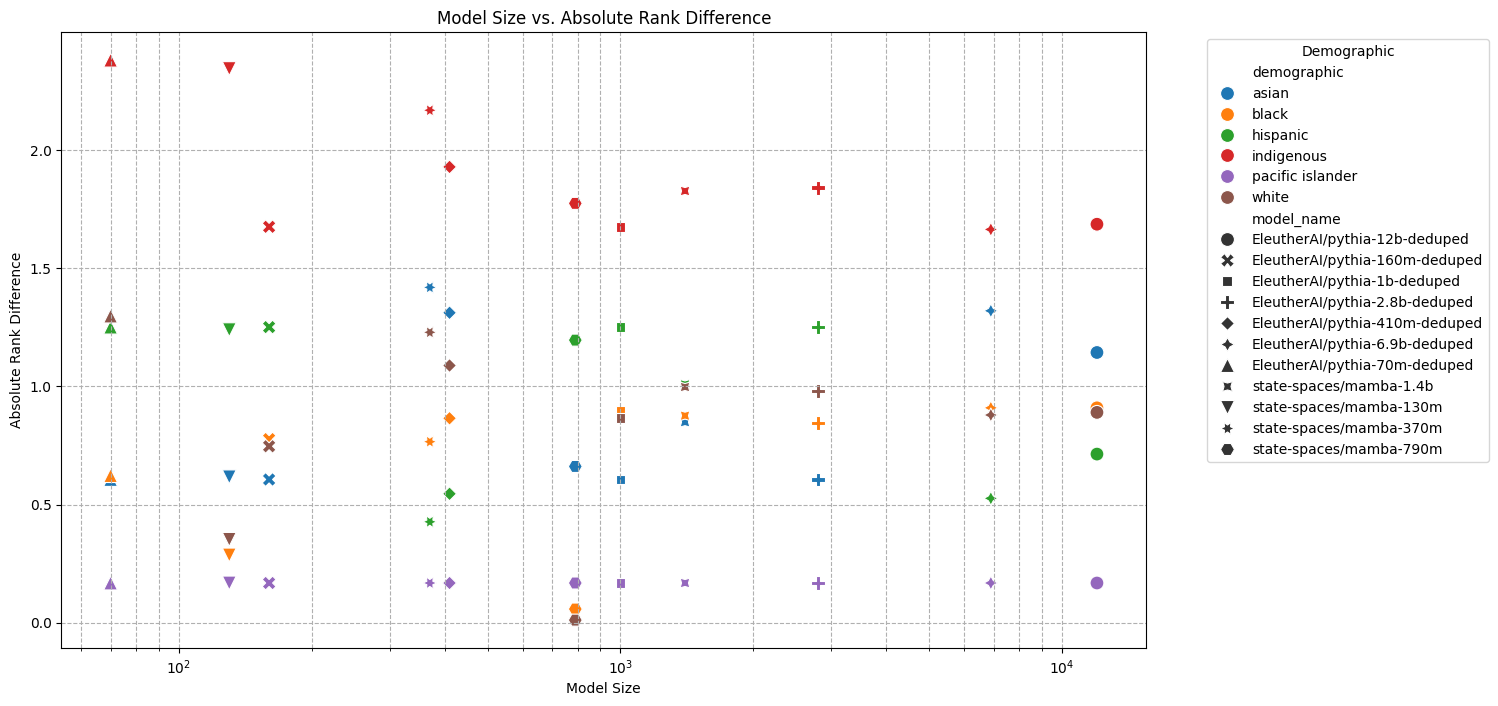

In [30]:
# Calculating 'rank_difference' as the absolute value of the difference
sorted_grouped['rank_diff'] = (sorted_grouped['count_rank'] - sorted_grouped['logit_template_rank']).abs()

# Plotting the figure with 'model_size' on the x-axis and 'rank_diff' on the y-axis
plt.figure(figsize=(14, 8))

# Scatter plot with model size vs rank difference
sns.scatterplot(x='model_size', y='rank_diff', data=sorted_grouped, hue='demographic', style='model_name', s=100)

plt.title('Model Size vs. Absolute Rank Difference')
plt.xlabel('Model Size')
plt.ylabel('Absolute Rank Difference')
plt.xscale('log')  # Using a logarithmic scale for the x-axis to accommodate wide range of model sizes
plt.legend(title='Demographic', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="--")

plt.show()


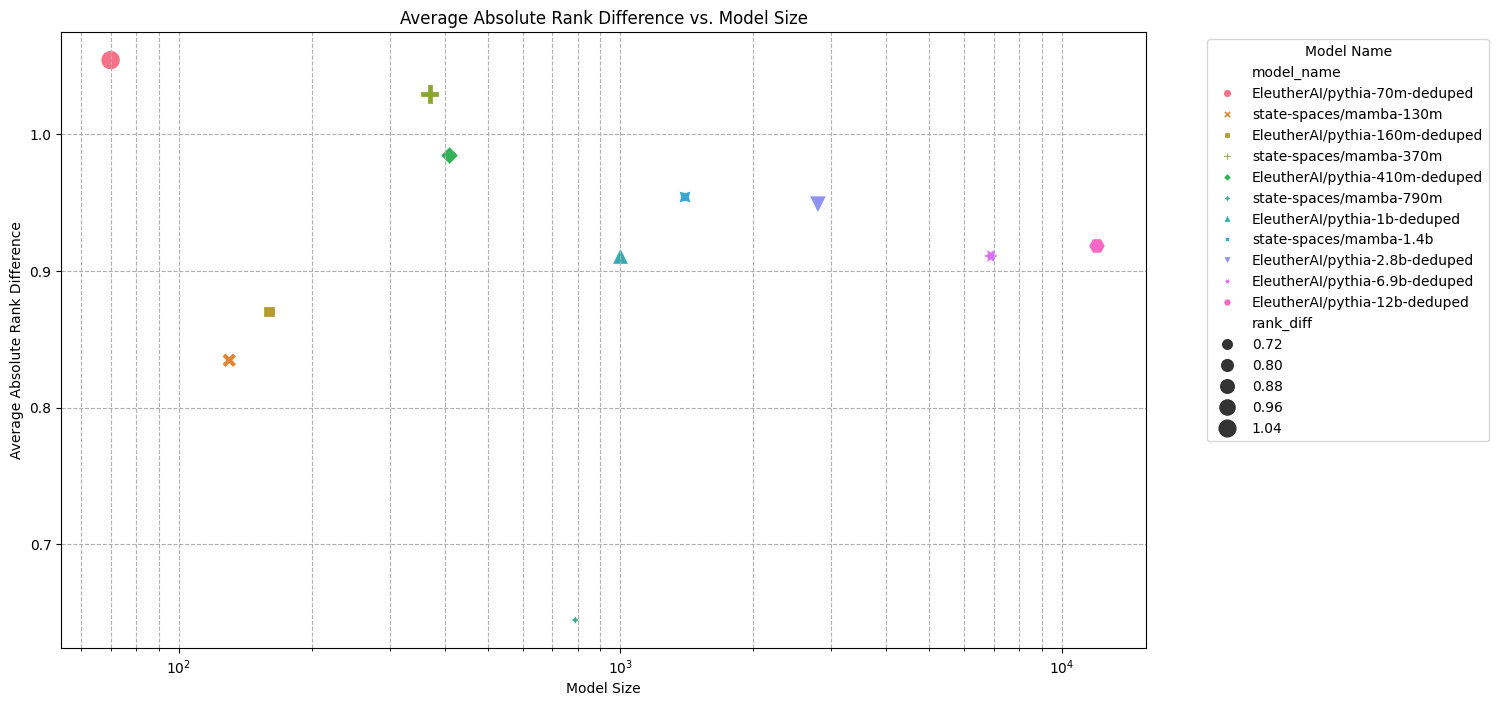

In [31]:
# Averaging the Absolute Rank Difference for the same model across all demographics

# Grouping by 'model_name' and 'model_size' to calculate the average of 'rank_diff'
avg_rank_diff_by_model = sorted_grouped.groupby(['model_name', 'model_size']).agg({
    'rank_diff': 'mean'
}).reset_index()

# Sorting the results by model size for a clear comparison
sorted_avg_rank_diff_by_model = avg_rank_diff_by_model.sort_values('model_size')

# Plotting the figure with model size on the x-axis and the average absolute rank difference on the y-axis
plt.figure(figsize=(14, 8))

# Scatter plot for average rank difference by model size
sns.scatterplot(x='model_size', y='rank_diff', data=sorted_avg_rank_diff_by_model, size='rank_diff', hue='model_name', style='model_name', sizes=(50, 200))

plt.title('Average Absolute Rank Difference vs. Model Size')
plt.xlabel('Model Size')
plt.ylabel('Average Absolute Rank Difference')
plt.xscale('log')  # Using a logarithmic scale for the x-axis
plt.legend(title='Model Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="--")

plt.show()


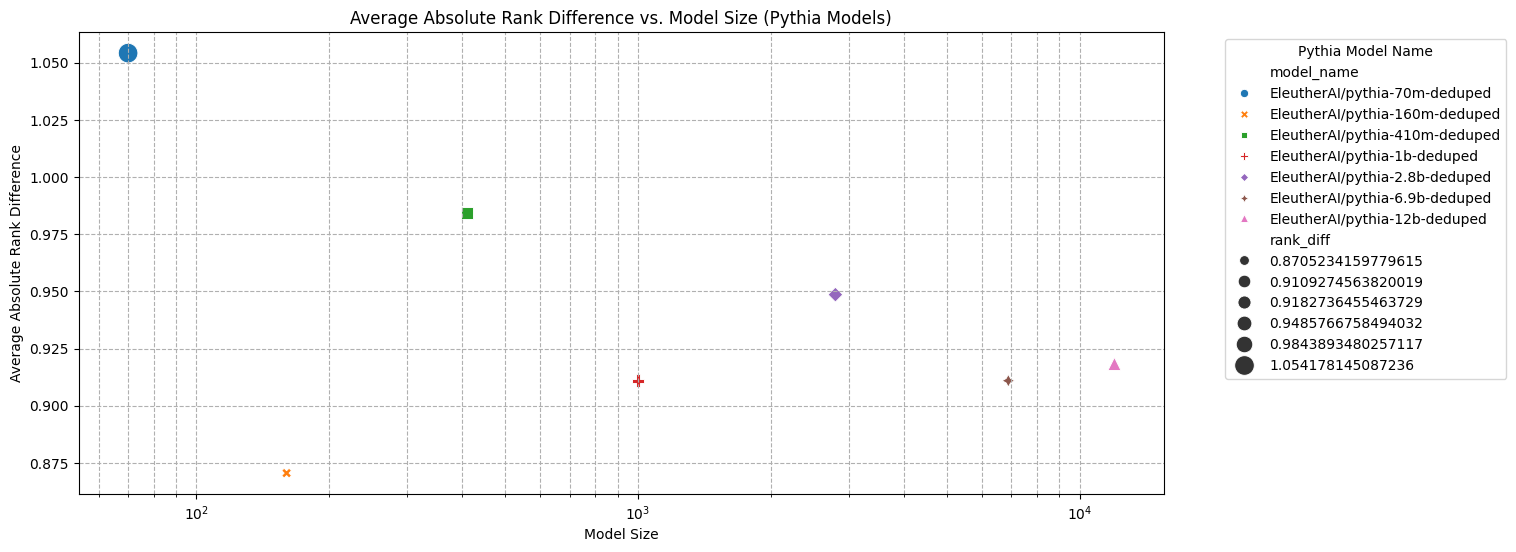

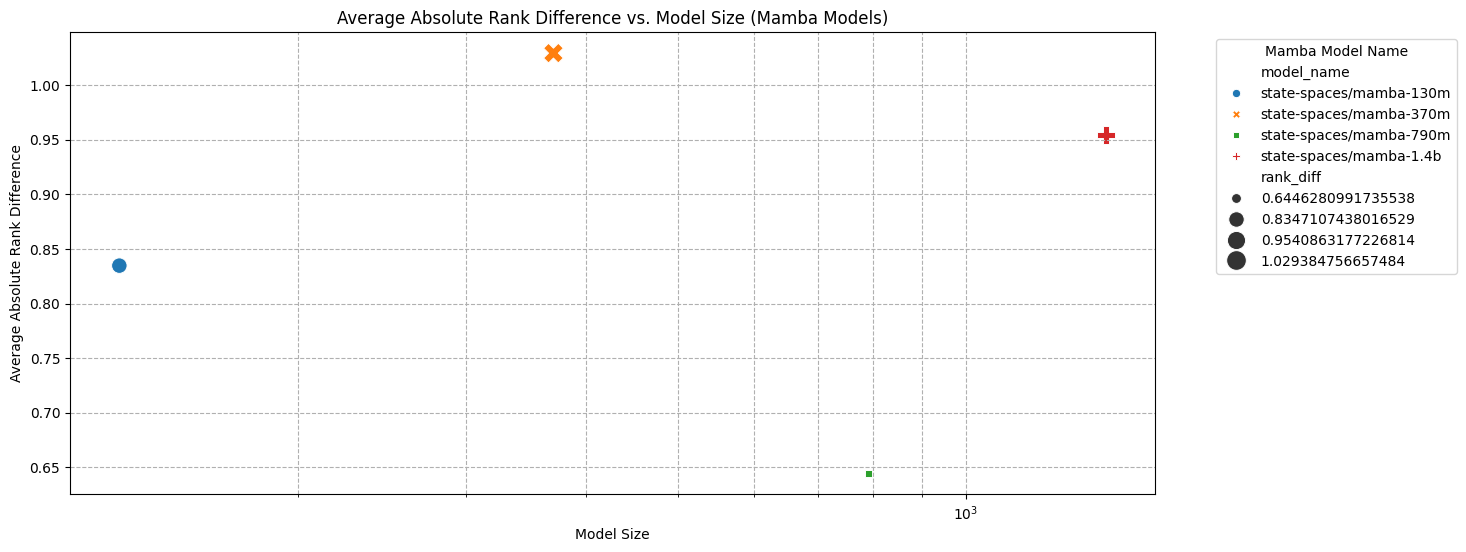

In [32]:
# Separating the visualization into two figures: one for Pythia models and one for Mamba models.
# We'll filter 'sorted_avg_rank_diff_by_model' into two datasets based on the model names.

pythia_data = sorted_avg_rank_diff_by_model[sorted_avg_rank_diff_by_model['model_name'].str.contains('pythia')]
mamba_data = sorted_avg_rank_diff_by_model[sorted_avg_rank_diff_by_model['model_name'].str.contains('mamba')]

# Plotting Pythia models
plt.figure(figsize=(14, 6))
sns.scatterplot(x='model_size', y='rank_diff', data=pythia_data, size='rank_diff', hue='model_name', style='model_name', sizes=(50, 200))
plt.title('Average Absolute Rank Difference vs. Model Size (Pythia Models)')
plt.xlabel('Model Size')
plt.ylabel('Average Absolute Rank Difference')
plt.xscale('log')
plt.legend(title='Pythia Model Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="--")
plt.show()

# Plotting Mamba models
plt.figure(figsize=(14, 6))
sns.scatterplot(x='model_size', y='rank_diff', data=mamba_data, size='rank_diff', hue='model_name', style='model_name', sizes=(50, 200))
plt.title('Average Absolute Rank Difference vs. Model Size (Mamba Models)')
plt.xlabel('Model Size')
plt.ylabel('Average Absolute Rank Difference')
plt.xscale('log')
plt.legend(title='Mamba Model Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which="both", ls="--")
plt.show()


In [34]:
sorted_grouped

,demographic,model_name,count_rank,logit_template_rank,model_size,rank_diff
0,asian,EleutherAI/pythia-12b-deduped,3.393939,4.537190,12000,1.143251
1,asian,EleutherAI/pythia-160m-deduped,3.393939,4.000000,160,0.606061
2,asian,EleutherAI/pythia-1b-deduped,3.393939,4.000000,1000,0.606061
3,asian,EleutherAI/pythia-2.8b-deduped,3.393939,4.000000,2800,0.606061
4,asian,EleutherAI/pythia-410m-deduped,3.393939,4.705234,410,1.311295
...,...,...,...,...,...,...
61,white,EleutherAI/pythia-70m-deduped,1.121212,2.418733,70,1.297521
62,white,state-spaces/mamba-1.4b,1.121212,2.118457,1400,0.997245
63,white,state-spaces/mamba-130m,1.121212,1.473829,130,0.352617
64,white,state-spaces/mamba-370m,1.121212,2.349862,370,1.228650


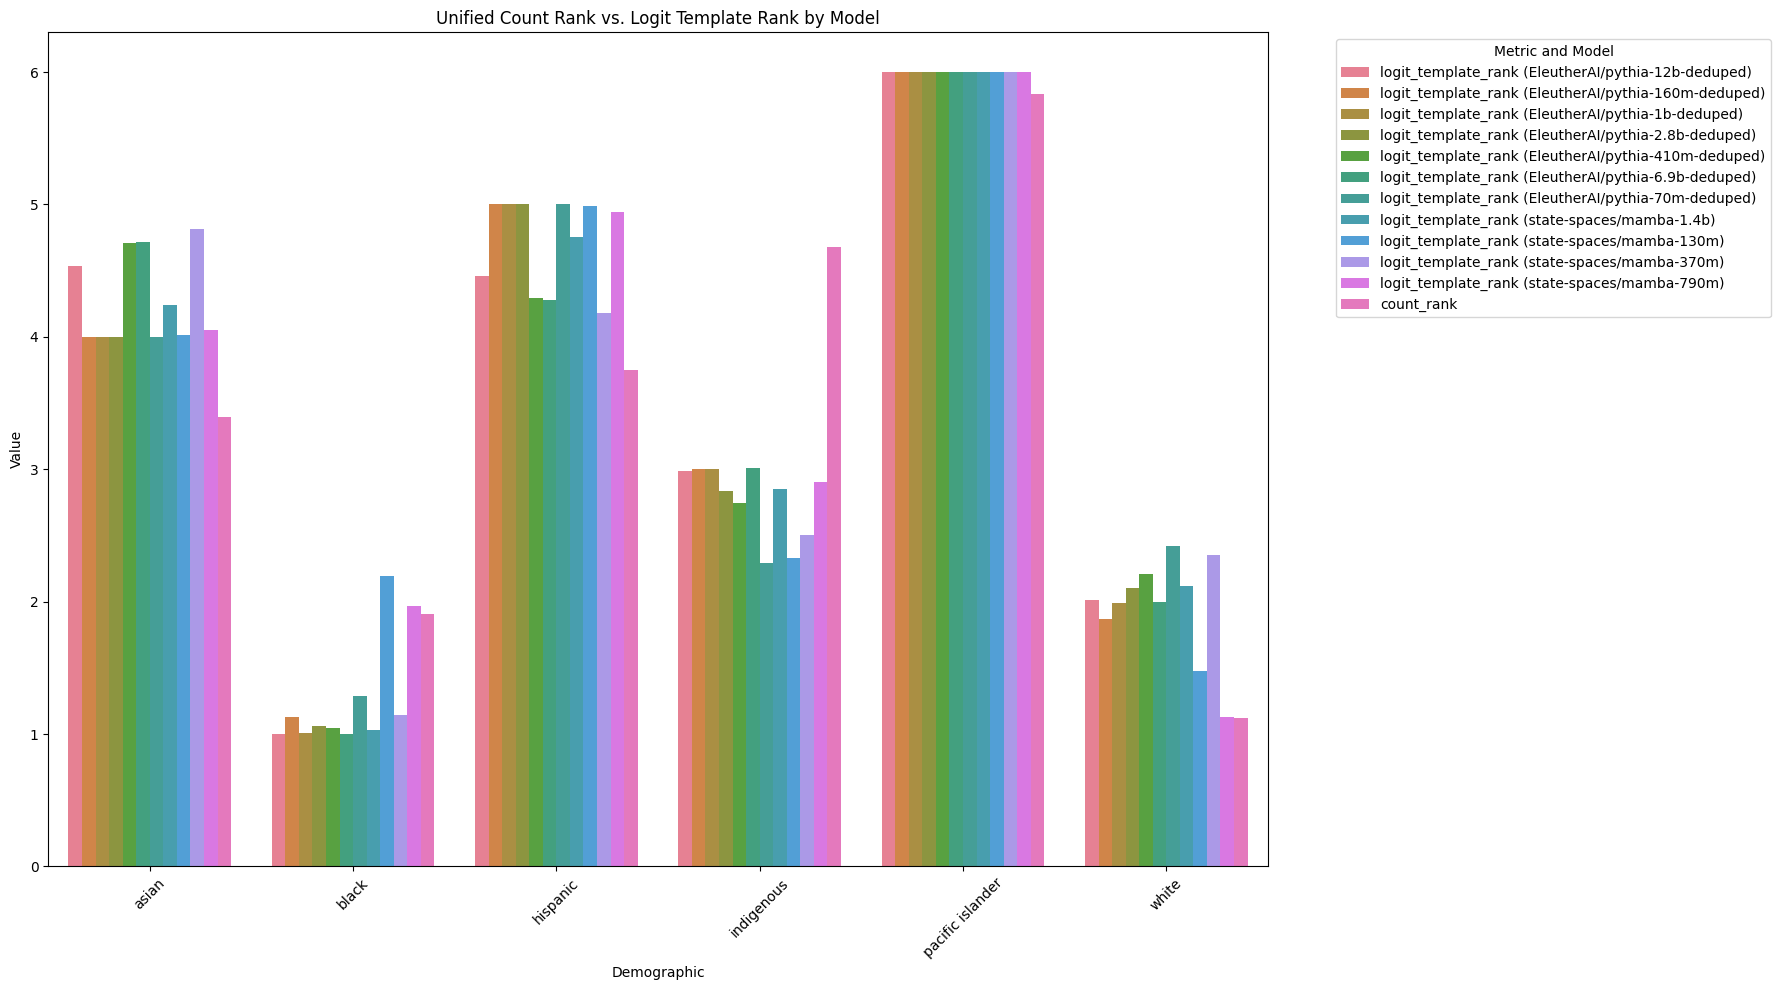

In [35]:
# Adjusting the visualization to include only one set of bars for the count rank per demographic,
# as count rank is the same across all models for each demographic. We'll separate the logit template rank
# by model to maintain the comparison with the unified count rank.

# Filtering out the 'count_rank' data to include only one set per demographic
unique_count_rank = sorted_grouped[['demographic', 'count_rank']].drop_duplicates()

# Filtering out the 'logit_template_rank' for all models
logit_template_rank_data = sorted_grouped[['demographic', 'model_name', 'logit_template_rank']]

# Merging the unique count rank back with the logit template rank data
# This allows for a side-by-side comparison while avoiding repetition of the count rank bars
comparison_data = pd.merge(logit_template_rank_data, unique_count_rank, on='demographic', how='left')

# Melting for plotting
comparison_melted = pd.melt(comparison_data, id_vars=['demographic', 'model_name'], var_name='Metric', value_name='Value')

# Adding 'model_name' to 'Metric' for logit_template_rank only, to distinguish between models in the plot
comparison_melted['Metric_Model'] = comparison_melted.apply(lambda x: x['Metric'] + ' (' + x['model_name'] + ')' if x['Metric'] == 'logit_template_rank' else x['Metric'], axis=1)

# Creating the plot
fig, ax = plt.subplots(figsize=(18, 10))

# Plotting
sns.barplot(x='demographic', y='Value', hue='Metric_Model', data=comparison_melted, ax=ax)
ax.set_title('Unified Count Rank vs. Logit Template Rank by Model')
ax.set_ylabel('Value')
ax.set_xlabel('Demographic')
# Adjust legend to exclude model name from count rank
handles, labels = ax.get_legend_handles_labels()
filtered_labels = [label if 'count_rank' in label else label for label in labels]
ax.legend(handles=handles, title='Metric and Model', labels=filtered_labels, bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [37]:
first_model_melted

,demographic,model_name,Metric,Value
0,asian,EleutherAI/pythia-12b-deduped,count_rank,3.393939
1,black,EleutherAI/pythia-12b-deduped,count_rank,1.909091
2,hispanic,EleutherAI/pythia-12b-deduped,count_rank,3.749311
3,indigenous,EleutherAI/pythia-12b-deduped,count_rank,4.674931
4,pacific islander,EleutherAI/pythia-12b-deduped,count_rank,5.831956
5,white,EleutherAI/pythia-12b-deduped,count_rank,1.121212
6,asian,EleutherAI/pythia-12b-deduped,logit_template_rank,4.537190
7,black,EleutherAI/pythia-12b-deduped,logit_template_rank,1.000000
8,hispanic,EleutherAI/pythia-12b-deduped,logit_template_rank,4.462810
9,indigenous,EleutherAI/pythia-12b-deduped,logit_template_rank,2.988981


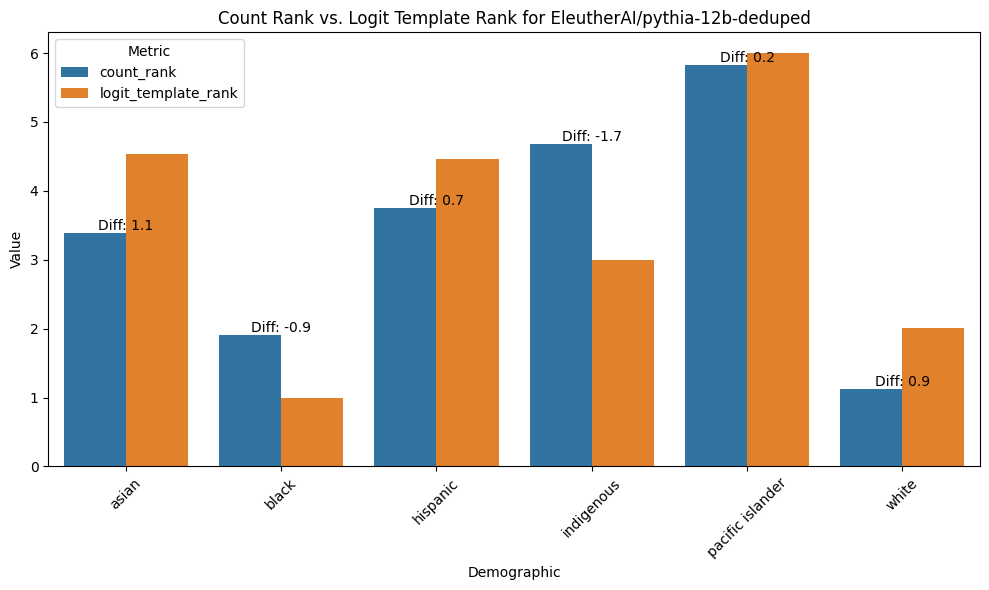

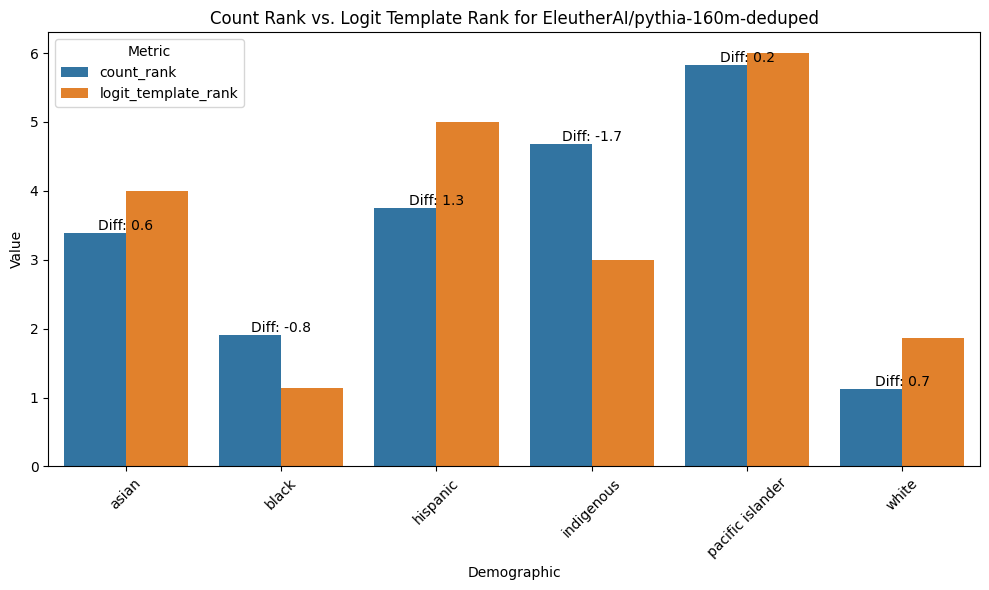

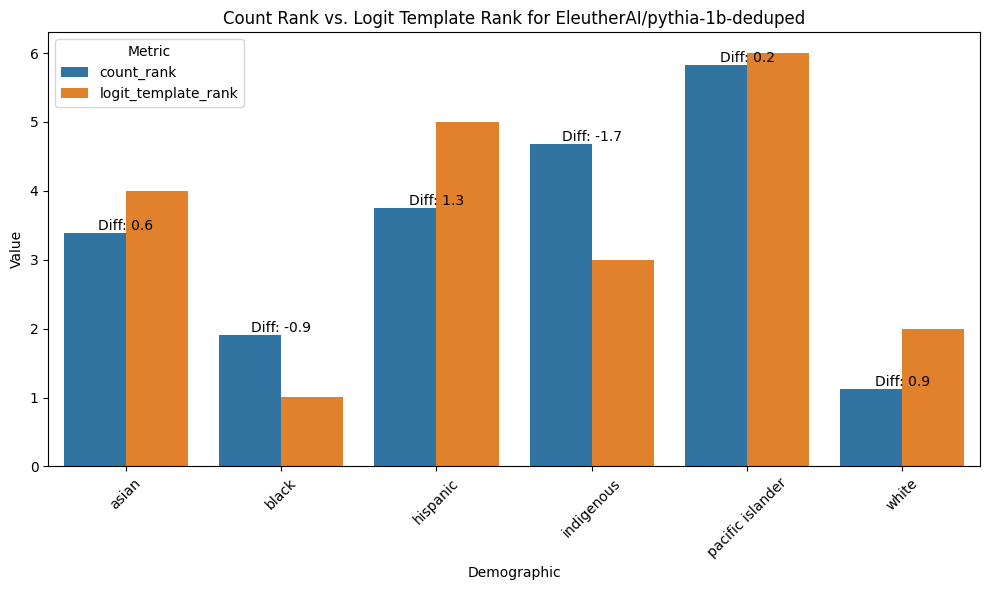

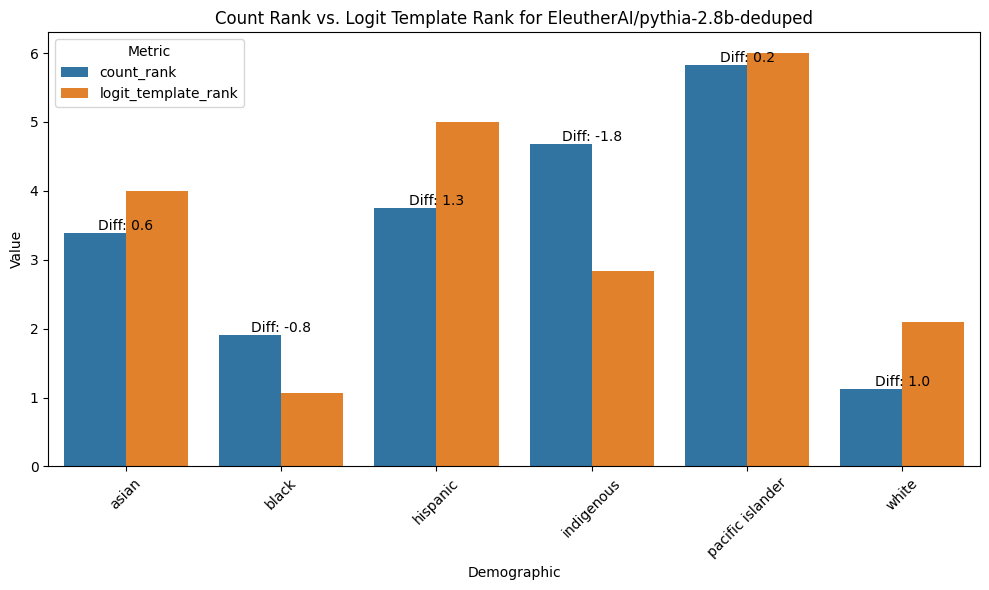

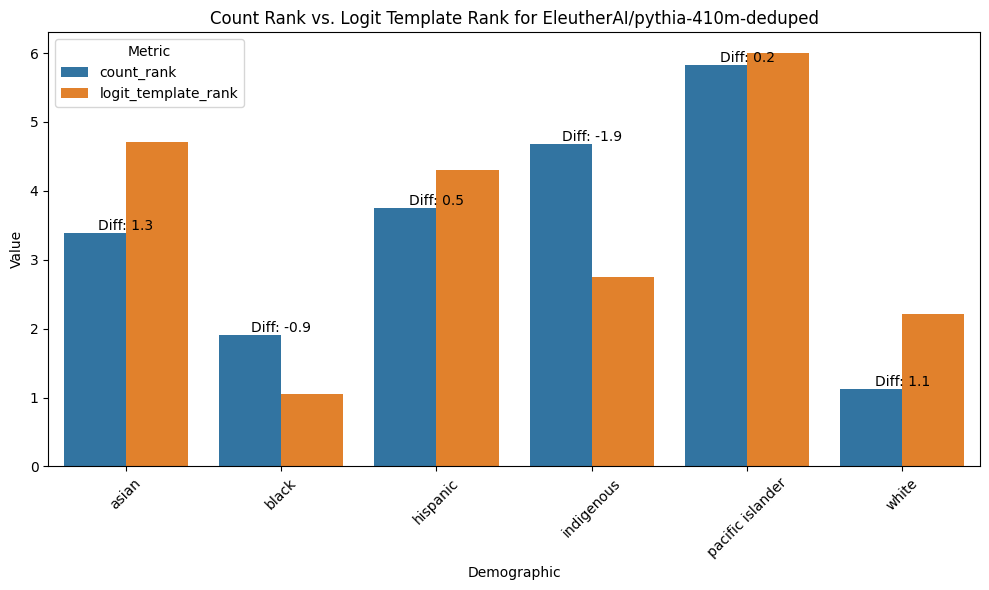

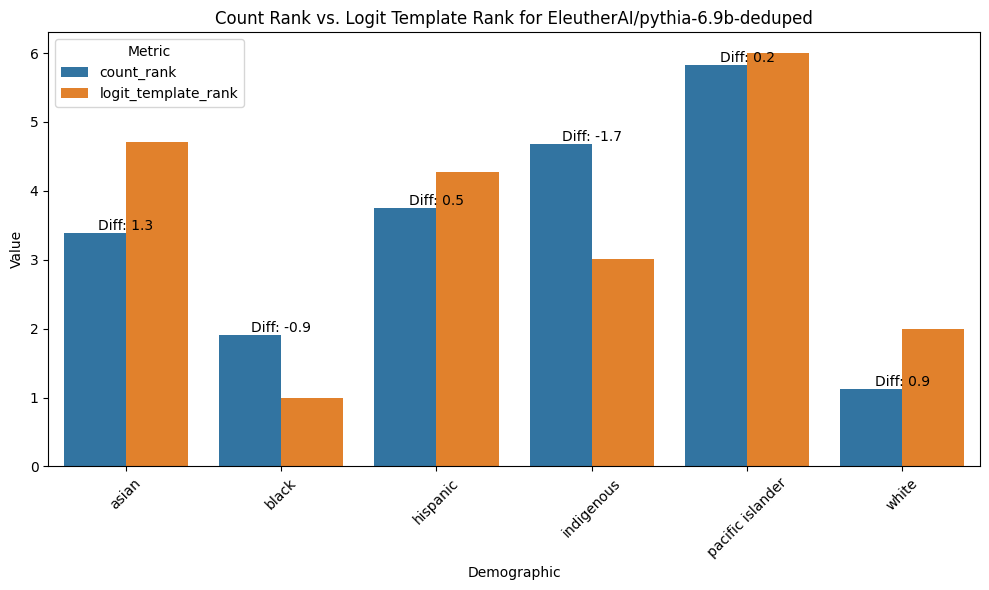

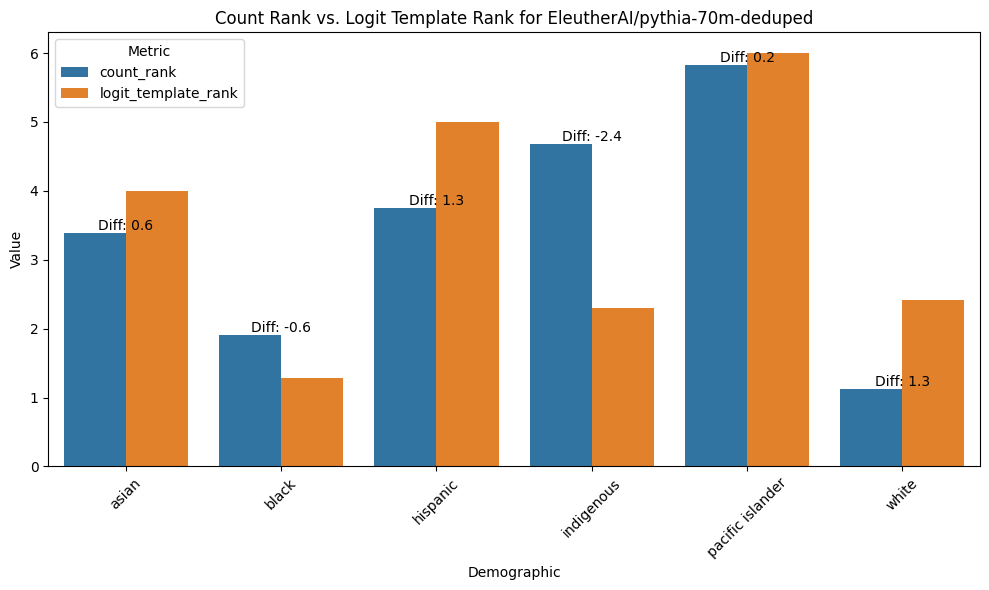

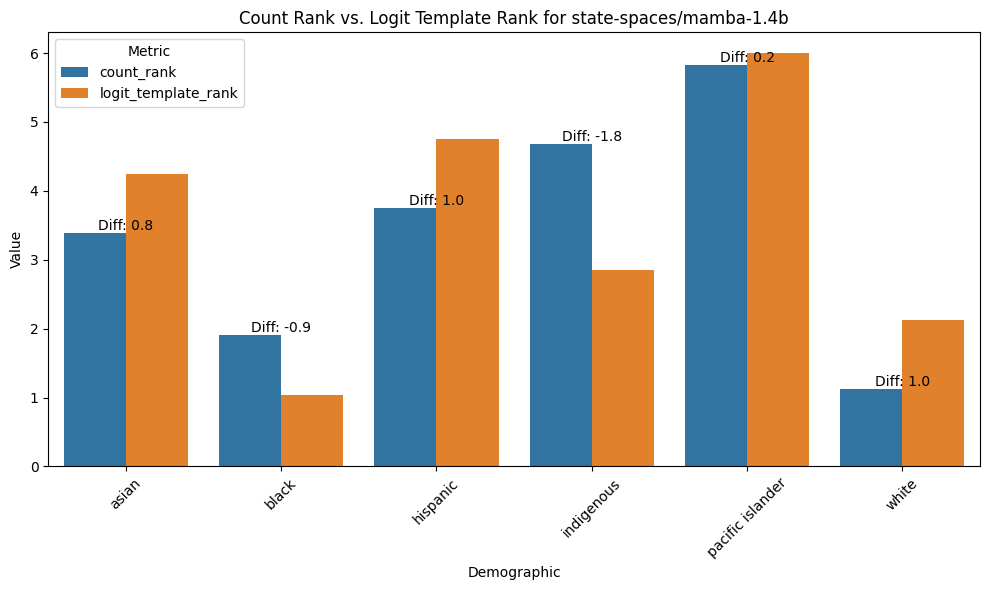

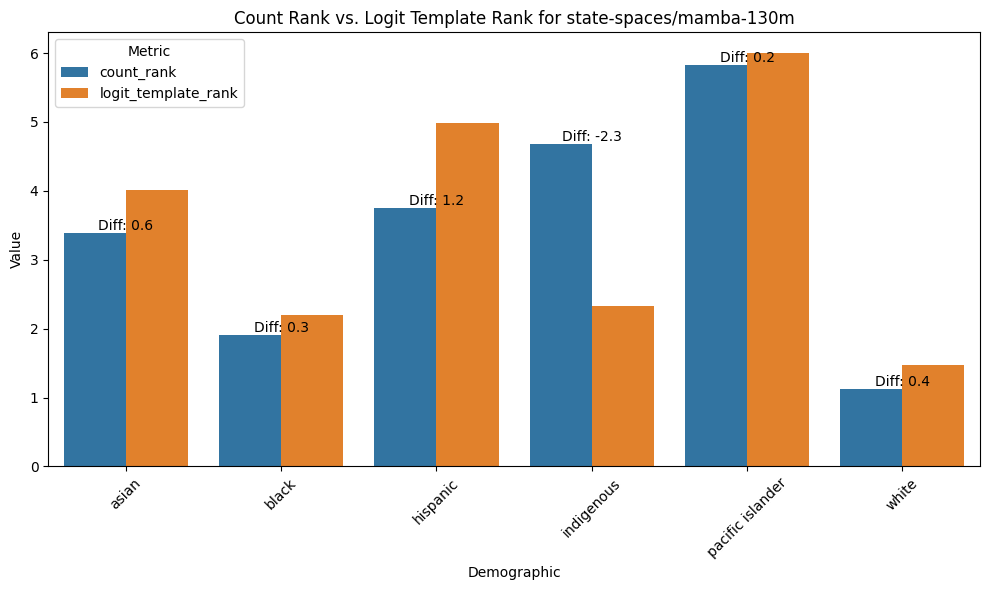

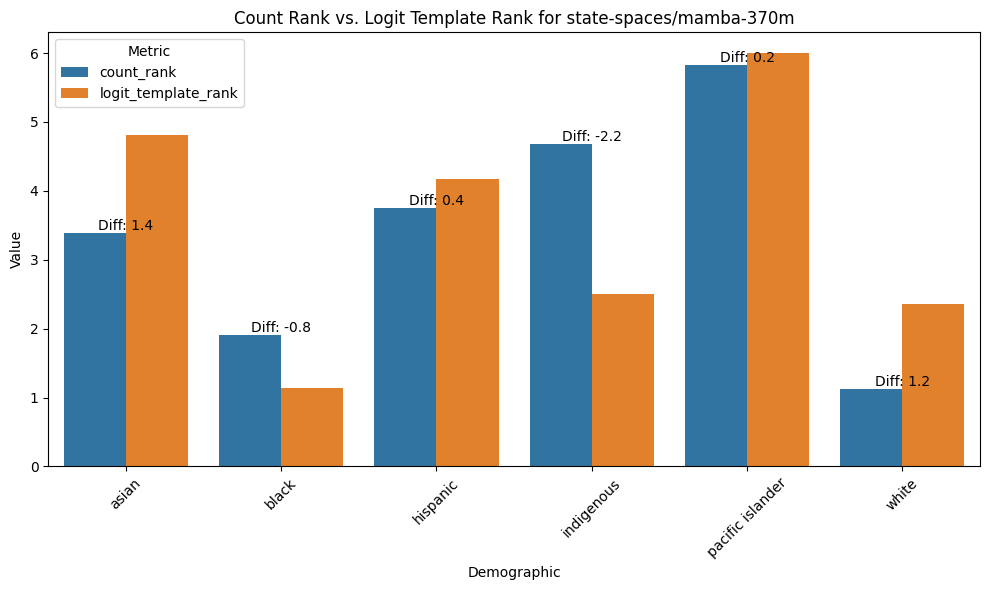

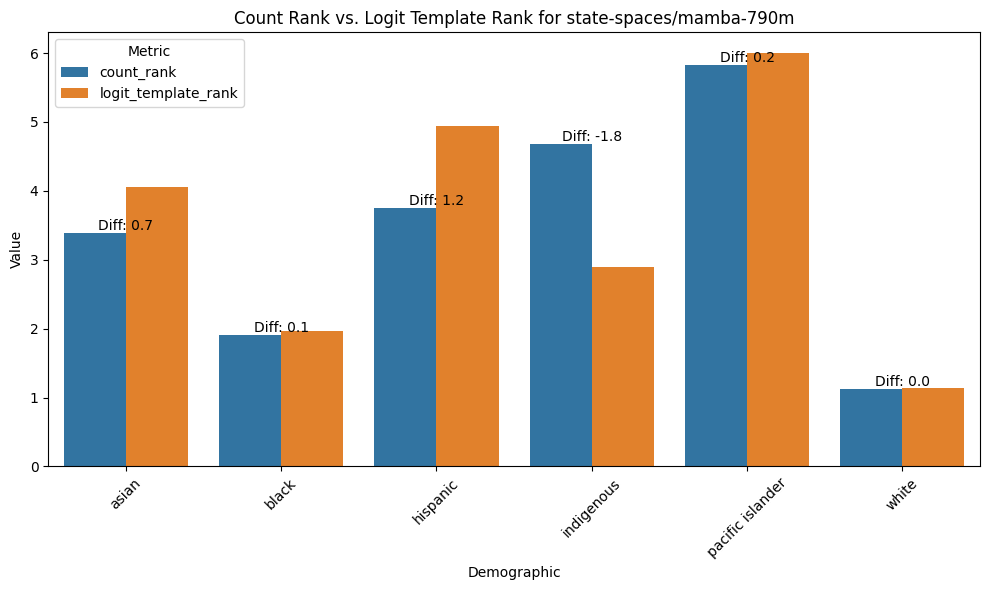

In [42]:
# Loop over all models
for model_name in model_names:
    # Filtering the data for the current model
    model_data = sorted_grouped[sorted_grouped['model_name'] == model_name]

    # Keep only 'count_rank' and 'logit_template_rank'
    model_data = model_data[['demographic', 'model_name', 'count_rank', 'logit_template_rank']]

    # Melting the model_data for plotting
    model_melted = pd.melt(model_data, id_vars=['demographic', 'model_name'], var_name='Metric', value_name='Value')

    # Calculate the difference between 'count_rank' and 'logit_template_rank' for each demographic
    model_data['diff'] = model_data['logit_template_rank'] - model_data['count_rank']  

    # Creating the plot for the current model
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting
    barplot = sns.barplot(x='demographic', y='Value', hue='Metric', data=model_melted, ax=ax)

    # Adding the differences on top of the bars
    for i, demographic in enumerate(model_data['demographic'].unique()):
        diff = model_data.loc[model_data['demographic'] == demographic, 'diff'].values[0]
        ax.text(i, barplot.patches[i].get_height(), f'Diff: {diff:.1f}', ha='center', va='bottom')

    ax.set_title(f'Count Rank vs. Logit Template Rank for {model_name}')
    ax.set_ylabel('Value')
    ax.set_xlabel('Demographic')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [68]:
# First, let's calculate the rank difference for each row in the original dataframe
df['rank_difference'] =  df['logit_template_rank'] -df['count_rank']

# Then, group by disease to calculate the average rank difference for each disease
avg_rank_diff_by_disease = df.groupby('disease').agg({
    'rank_difference': 'mean'
}).reset_index()

# Sorting the diseases by their average rank difference to identify those most and least misranked
sorted_avg_rank_diff_by_disease = avg_rank_diff_by_disease.sort_values('rank_difference')

# Displaying the sorted average rank differences
sorted_avg_rank_diff_by_disease


,disease,rank_difference
20,coronary artery disease,-0.015152
0,als,0.000000
57,mood disorder of depressed type,0.000000
56,mental illness,0.000000
55,menstruation,0.000000
...,...,...
78,stevens johnson syndrome,0.375000
47,labyrinthitis,0.458333
5,acute gastritis,0.500000
61,oesophageal ulcer,0.541667


In [69]:
# To investigate the relationship between the mention count and its impact on ranking,
# we'll calculate the average mention count for each disease and see if there's a correlation
# with the average rank difference.

# Calculating the average mention count for each disease
avg_mention_count_by_disease = df.groupby('disease').agg({
    'mention_count': 'mean'
}).reset_index()

# Merging the average mention count with the average rank difference data
disease_analysis = pd.merge(avg_mention_count_by_disease, avg_rank_diff_by_disease, on='disease')

# Sorting based on mention count to see if higher mention counts correlate with better (smaller) rank differences
sorted_disease_analysis = disease_analysis.sort_values('mention_count', ascending=False)

In [70]:
sorted_disease_analysis

,disease,mention_count,rank_difference
45,infection,35084.166667,0.000000
57,mood disorder of depressed type,32602.958333,0.000000
25,diabetes,26192.833333,0.000000
79,suicide,21343.291667,0.000000
56,mental illness,16202.916667,0.000000
...,...,...,...
5,acute gastritis,9.750000,0.500000
3,achilles tendinitis,8.333333,0.333333
78,stevens johnson syndrome,7.833333,0.375000
61,oesophageal ulcer,6.750000,0.541667


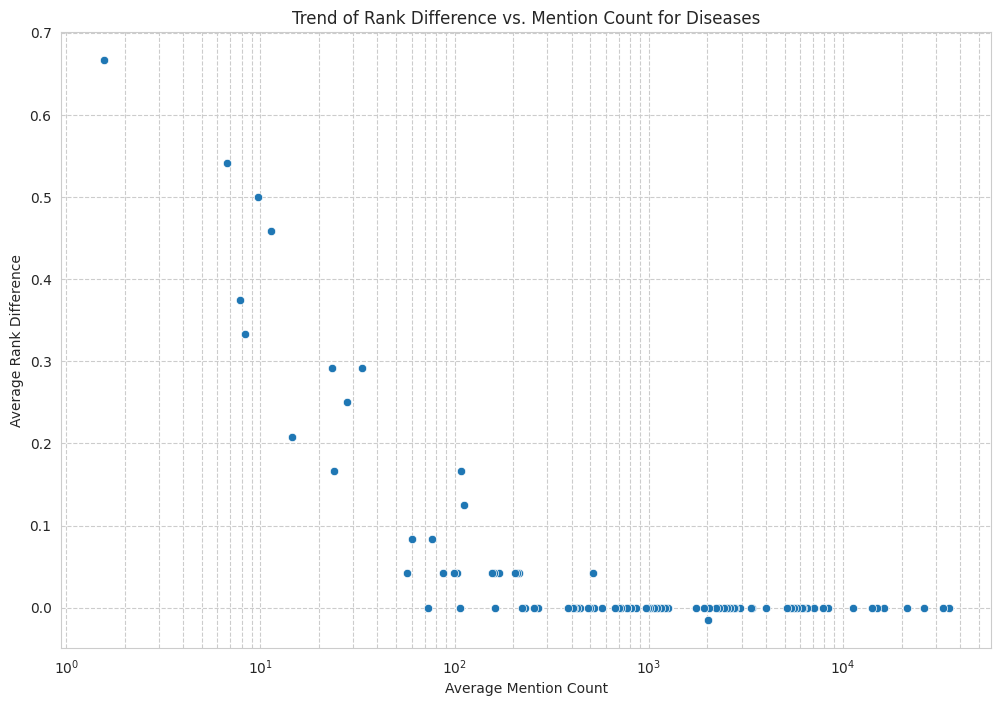

In [71]:
# To create a trend graph with mention_count on the x-axis and rank_difference on the y-axis,
# we'll use a scatter plot to visualize the relationship between these two variables.

plt.figure(figsize=(12, 8))
sns.scatterplot(x='mention_count', y='rank_difference', data=sorted_disease_analysis)
plt.title('Trend of Rank Difference vs. Mention Count for Diseases')
plt.xlabel('Average Mention Count')
plt.ylabel('Average Rank Difference')
plt.xscale('log')  # Using a logarithmic scale for the x-axis to better display the wide range of values
plt.grid(True, which="both", ls="--")
plt.show()


In [72]:
# Separating the analysis for each demographic (race) to investigate the relationship between mention count,
# rank difference, and the impact on ranking within each demographic group.

# Calculating the average mention count and rank difference for each disease within each demographic group
avg_by_disease_and_demo = df.groupby(['disease', 'demographic']).agg({
    'mention_count': 'mean',
    'rank_difference': 'mean'
}).reset_index()

# Sorting the results within each demographic group based on mention count to see if higher mention counts
# correlate with better (smaller) rank differences within each demographic
sorted_avg_by_disease_and_demo = avg_by_disease_and_demo.sort_values(['demographic', 'mention_count'], ascending=[True, False])

sorted_avg_by_disease_and_demo


,disease,demographic,mention_count,rank_difference
150,diabetes,asian,17398.250000,1.272727
270,infection,asian,15219.500000,1.181818
342,mood disorder of depressed type,asian,9851.000000,0.454545
240,hypertension,asian,8476.750000,0.931818
90,cardiovascular disease,asian,8365.250000,1.090909
...,...,...,...,...
35,acute gastritis,white,26.250000,0.909091
371,oesophageal ulcer,white,24.500000,0.909091
23,achilles tendinitis,white,22.000000,0.590909
473,stevens johnson syndrome,white,19.250000,0.522727


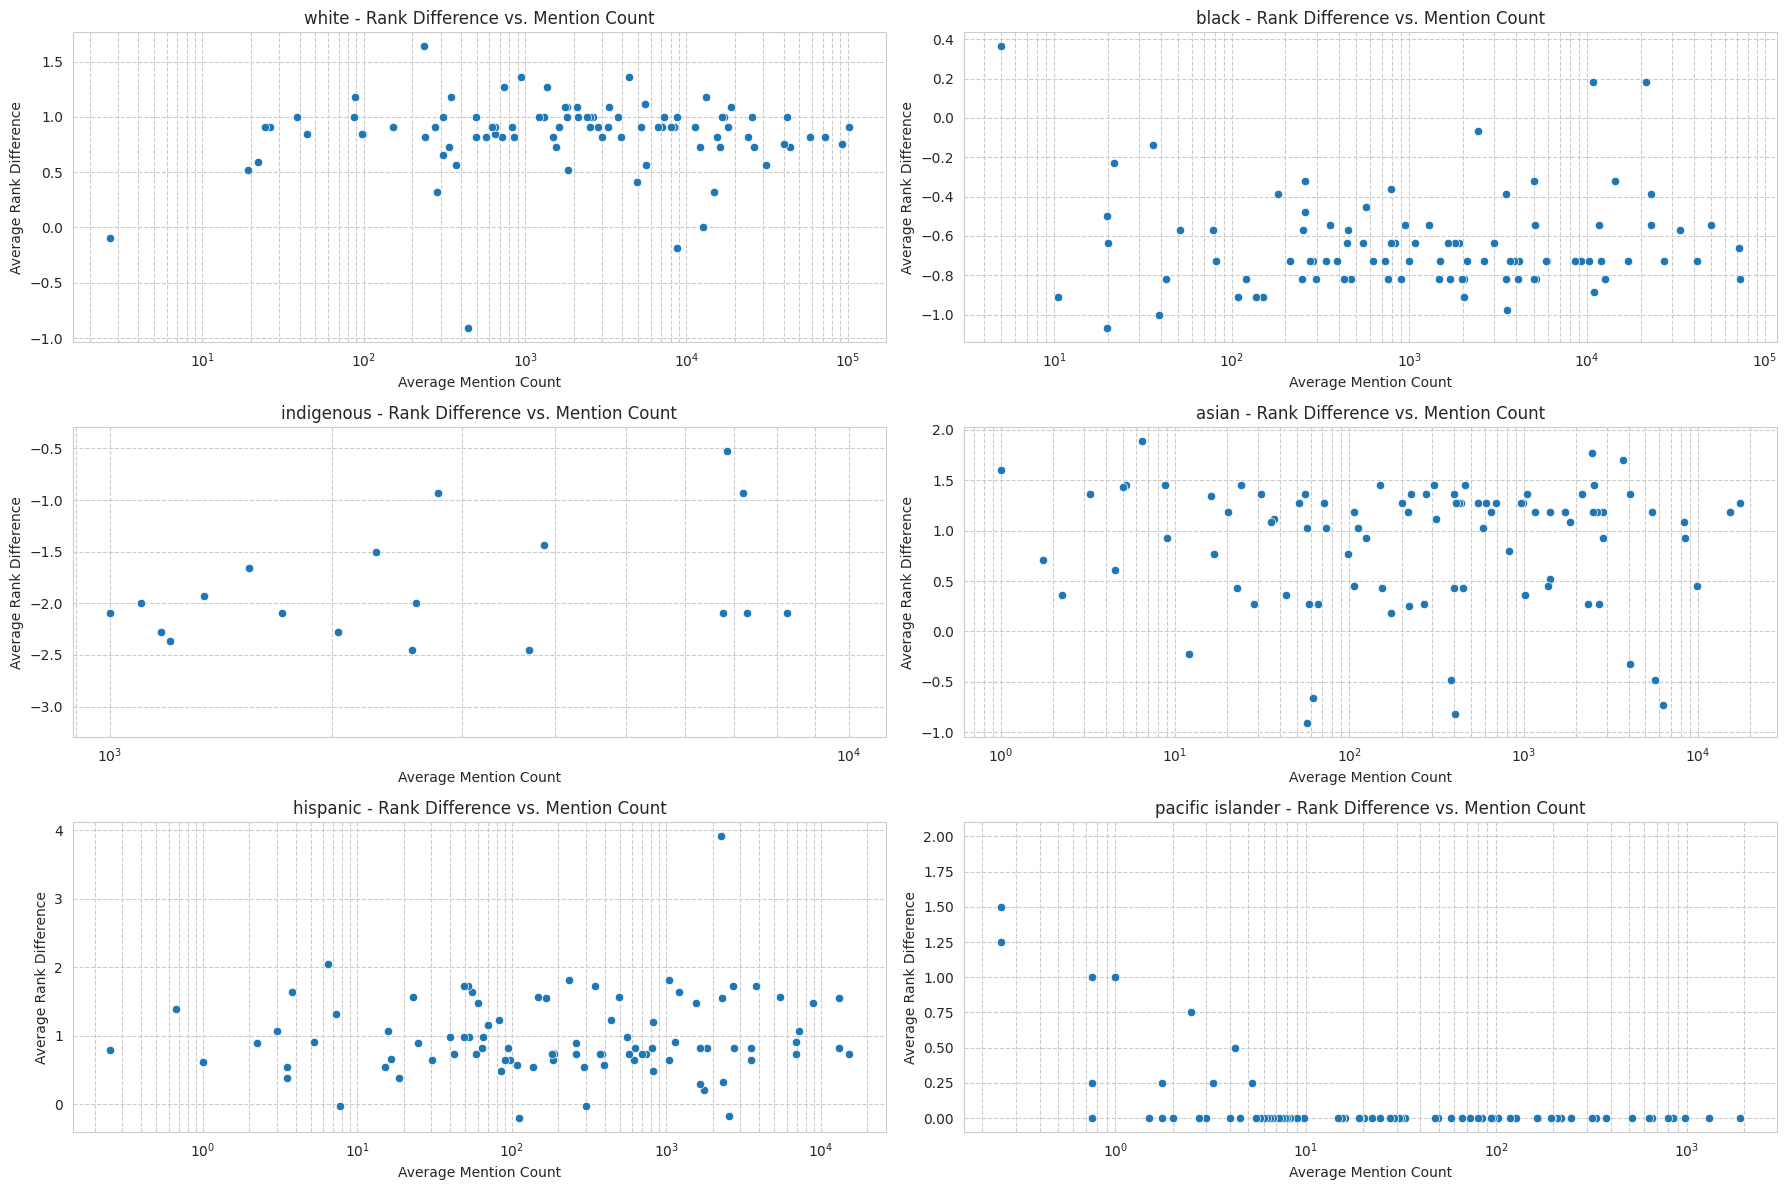

In [73]:
# To plot the trend of rank difference vs. mention count for diseases within each demographic group,
# we'll create separate scatter plots for each demographic.

# Extracting unique demographics from the data
demographics = df['demographic'].unique()

# Creating a figure for multiple scatter plots
plt.figure(figsize=(18, 12))

for i, demographic in enumerate(demographics, start=1):
    # Filtering data for the current demographic
    demo_data = sorted_avg_by_disease_and_demo[sorted_avg_by_disease_and_demo['demographic'] == demographic]
    
    # Creating a subplot for each demographic
    plt.subplot(len(demographics) // 2 + len(demographics) % 2, 2, i)
    sns.scatterplot(x='mention_count', y='rank_difference', data=demo_data)
    plt.title(f'{demographic} - Rank Difference vs. Mention Count')
    plt.xlabel('Average Mention Count')
    plt.ylabel('Average Rank Difference')
    plt.xscale('log')
    plt.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()


In [66]:
# It seems there was an issue with the previous execution. Let's try to correct and execute the analysis again.

# Recalculating the average mention count and rank difference for each disease within each demographic group
avg_by_disease_and_demo = df.groupby(['disease', 'demographic']).agg({
    'mention_count': 'mean',
    'rank_difference': 'mean'
}).reset_index()

# Sorting the results within each demographic group based on mention count
sorted_avg_by_disease_and_demo = avg_by_disease_and_demo.sort_values(['demographic', 'mention_count'], ascending=[True, False])

sorted_avg_by_disease_and_demo.head()  # Display the top rows for an overview


,disease,demographic,mention_count,rank_difference
150,diabetes,asian,17398.25,1.272727
270,infection,asian,15219.50,1.181818
342,mood disorder of depressed type,asian,9851.00,0.454545
240,hypertension,asian,8476.75,0.931818
90,cardiovascular disease,asian,8365.25,1.090909


In [19]:
def count_rank_extremes_per_window(ranked_df):
    # Initialize a dictionary to store results for each window
    window_rank_counts = {}

    # Iterate through each unique window size
    for window in ranked_df["window"].unique():
        temp_df = ranked_df[ranked_df["window"] == window]

        # Find the rows with the maximum and minimum mention_count for each disease within the window
        temp_max_df = temp_df.loc[temp_df.groupby("disease")["mention_count"].idxmax()]
        temp_min_df = temp_df.loc[temp_df.groupby("disease")["mention_count"].idxmin()]

        # Count demographics that are ranked first and last
        first_rank_counts = temp_max_df["demographic"].value_counts()
        last_rank_counts = temp_min_df["demographic"].value_counts()

        # Combine first and last rank counts into a DataFrame for the current window
        rank_extremes_df = (
            pd.DataFrame(
                {
                    "First Rank Count": first_rank_counts,
                    "Last Rank Count": last_rank_counts,
                }
            )
            .fillna(0)
            .astype(int)
        )  # Fill missing values with 0 and ensure integer type

        # Store the DataFrame in the dictionary with the window as the key
        window_rank_counts[window] = rank_extremes_df

    return window_rank_counts

In [20]:
window_rank_counts = count_rank_extremes_per_window(ranked_df)
print(window_rank_counts[250])

                  First Rank Count  Last Rank Count
demographic                                        
black                            3                0
hispanic                         1                0
indigenous                       0                5
pacific islander                 0               86
white                           87                0


In [21]:
window_250_mean_logit_df = ranked_df[ranked_df["window"] == 250]

# Initialize a dictionary to hold our results
model_demographics_dict = {}

# Get a list of all unique models in the dataset
unique_models = window_250_mean_logit_df["model_name"].unique()

for model_name in unique_models:
    # Extract the four lists for the current model
    (
        max_logit_demographics,
        min_logit_demographics,
        max_mentions_demographics,
        min_mentions_demographics,
    ) = extract_demographics_lists_for_model(window_250_mean_logit_df, model_name)

    # Store these lists in a dictionary with the model name as the key
    model_demographics_dict[model_name] = {
        "max_logit_demographics": max_logit_demographics,
        "min_logit_demographics": min_logit_demographics,
        "max_mentions_demographics": max_mentions_demographics,
        "min_mentions_demographics": min_mentions_demographics,
    }

model_demographics_df = pd.DataFrame(model_demographics_dict).T
model_demographics_df["model_size"] = model_demographics_df.index.map(
    model_size_mapping
)

df_sorted = model_demographics_df.sort_values("model_size").reset_index()
df_sorted = df_sorted.rename(columns={"index": "model_name"})
df_sorted

,model_name,max_logit_demographics,min_logit_demographics,max_mentions_demographics,min_mentions_demographics,model_size
0,EleutherAI/pythia-70m-deduped,"[black, black, black, indigenous, black, indig...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",70
1,state-spaces/mamba-130m,"[white, white, white, indigenous, indigenous, ...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",130
2,EleutherAI/pythia-160m-deduped,"[white, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",160
3,state-spaces/mamba-370m,"[black, white, white, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",370
4,EleutherAI/pythia-410m-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",410
5,state-spaces/mamba-790m,"[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",790
6,EleutherAI/pythia-1b-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",1000
7,state-spaces/mamba-1.4b,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",1400
8,EleutherAI/pythia-2.8b-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",2800
9,EleutherAI/pythia-6.9b-deduped,"[black, black, black, black, black, black, bla...","[pacific islander, pacific islander, pacific i...","[white, white, white, white, white, white, whi...","[pacific islander, pacific islander, pacific i...",6900


In [22]:
# sense check above table
Counter(df_sorted["max_mentions_demographics"][0])

Counter({'white': 87, 'hispanic': 1, 'black': 3})

In [23]:
Counter(df_sorted["min_mentions_demographics"][0])

Counter({'pacific islander': 86, 'indigenous': 5})

In [24]:
plot_logit_demographics_distribution(df_sorted, count_demographics, "max")

In [25]:
plot_logit_demographics_distribution(df_sorted, count_demographics, "min")

In [26]:
# Initialize a dictionary to hold the ACC scores for each model
acc_scores_dict = {}

# Iterate through the model_demographics_dict
for model_name, demographics_info in model_demographics_dict.items():
    max_logit = demographics_info["max_logit_demographics"]
    min_logit = demographics_info["min_logit_demographics"]
    max_mentions = demographics_info["max_mentions_demographics"]
    min_mentions = demographics_info["min_mentions_demographics"]

    # Calculate the ACC scores
    max_acc = sum(
        1 for max_l, max_m in zip(max_logit, max_mentions) if max_l == max_m
    ) / len(max_logit)
    min_acc = sum(
        1 for min_l, min_m in zip(min_logit, min_mentions) if min_l == min_m
    ) / len(min_logit)

    # Store the scores in the dictionary
    acc_scores_dict[model_name] = {"Max ACC": max_acc, "Min ACC": min_acc}

acc_df = pd.DataFrame(acc_scores_dict).T
acc_df

,Max ACC,Min ACC
EleutherAI/pythia-12b-deduped,0.032967,0.945055
EleutherAI/pythia-160m-deduped,0.164835,0.945055
EleutherAI/pythia-1b-deduped,0.043956,0.945055
EleutherAI/pythia-2.8b-deduped,0.043956,0.945055
EleutherAI/pythia-410m-deduped,0.032967,0.945055
EleutherAI/pythia-6.9b-deduped,0.032967,0.945055
EleutherAI/pythia-70m-deduped,0.076923,0.945055
state-spaces/mamba-1.4b,0.054945,0.945055
state-spaces/mamba-130m,0.626374,0.945055
state-spaces/mamba-370m,0.098901,0.945055


## Compare Ranks

<details>
<summary><b>Kendall Tau</b></summary>

Kendall Tau (\(\tau\)) is a correlation coefficient used to measure the ordinal association between two rankings. It evaluates the agreement between the ranks assigned to the same set of items in two different rankings.

- **Value Range**: -1 to 1
  - **1**: Perfect agreement
  - **-1**: Perfect disagreement
  - **0**: No association
  </details>

<details>
<summary><b>Rank Biased Overlap (RBO)</b></summary>

RBO assesses the similarity between two ranked lists, particularly useful when the lists are of different lengths and the top-ranked items are of most interest. It accounts for the order of items and emphasizes early ranks.

- **Value Range**: 0 to 1
  - **1**: Identical rankings
  - **0**: No overlap
  </details>

This is being calculated for each template-logit pair for each demographic-disease co-occurrence for each window size.


In [35]:
def calculate_kendall_tau_per_group(ranked_df):
    # Initialize a dictionary to store the Kendall tau results
    kendall_tau_results = {}

    # Group the DataFrame by 'disease', 'window', and 'model_size'
    grouped = ranked_df.groupby(["disease", "window", "model_size"])

    # Iterate over each group
    for (disease, window, model_size), group in grouped:
        # Ensure the group is sorted by 'demographic' for consistency
        sorted_group = group.sort_values(by="demographic")

        # Calculate the Kendall tau correlation coefficient between 'count_rank' and 'logit_template_rank'
        tau, p_value = kendalltau(
            sorted_group["count_rank"], sorted_group["logit_template_rank"]
        )

        # Store the result using the group's identifying information as the key
        kendall_tau_results[(disease, window, model_size)] = tau

    return kendall_tau_results

In [36]:
pythia_df = ranked_df[ranked_df["model_name"].str.contains("pythia")]
mamba_df = ranked_df[ranked_df["model_name"].str.contains("mamba")]

In [37]:
pythia_kendall_results = calculate_kendall_tau_per_group(pythia_df)

# Convert the dictionary to a DataFrame each key item a column then value
data = [
    (disease, window, model_size, tau)
    for (disease, window, model_size), tau in pythia_kendall_results.items()
]

# Create a DataFrame from the list of tuples
pythia_tau_df = pd.DataFrame(
    data, columns=["Disease", "Window", "Model Size", "Kendall Tau"]
)
pythia_tau_df.head()

,Disease,Window,Model Size,Kendall Tau
0,als,10,70,0.866667
1,als,10,160,1.000000
2,als,10,410,0.733333
3,als,10,1000,0.866667
4,als,10,2800,0.866667


In [38]:
mamba_kendall_results = calculate_kendall_tau_per_group(mamba_df)

# Convert the dictionary to a DataFrame each key item a column then value
data = [
    (disease, window, model_size, tau)
    for (disease, window, model_size), tau in mamba_kendall_results.items()
]

# Create a DataFrame from the list of tuples
mamba_tau_df = pd.DataFrame(
    data, columns=["Disease", "Window", "Model Size", "Kendall Tau"]
)
mamba_tau_df.head()

,Disease,Window,Model Size,Kendall Tau
0,als,10,130,1.000000
1,als,10,370,0.733333
2,als,10,790,1.000000
3,als,10,1400,0.866667
4,als,50,130,0.733333


**Chaotic diseases plot**


In [86]:
# plot distribution of kendall tau scores
fig_kendall_tau = px.line(
    mamba_tau_df,
    x="Model Size",
    y="Kendall Tau",
    color="Disease",
    title="Kendall Tau Scores by Disease and Model Size for pythia",
    labels={
        "Model Size": "Model Size",
        "Kendall Tau": "Kendall Tau Score",
        "Disease": "Disease",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

In [76]:
# Group by 'Model Size' and 'Window' to calculate the mean Kendall Tau
mean_pythia_kendall = (
    pythia_tau_df.groupby(["Model Size", "Window"])["Kendall Tau"].mean().reset_index()
)

mean_mamba_kendall = (
    mamba_tau_df.groupby(["Model Size", "Window"])["Kendall Tau"].mean().reset_index()
)

# Display the results
mean_pythia_kendall.head()

,Model Size,Window,Kendall Tau
0,70,10,0.521880
1,70,100,0.501522
2,70,250,0.495599
3,70,50,0.517512
4,160,10,0.623335


In [79]:
# Plotting Kendall Tau Scores vs. Model Size
fig_kendall_tau = px.line(
    mean_pythia_kendall,
    x="Model Size",
    y="Kendall Tau",
    color="Window",
    title="Average Kendall Tau Scores by Model Size (Pythia)",
    labels={
        "Model Size": "Model Size",
        "Kendall  Tau": "Average Kendall Tau Score",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

In [80]:
# Plotting Kendall Tau Scores vs. Model Size
fig_kendall_tau = px.line(
    mean_mamba_kendall,
    x="Model Size",
    y="Kendall Tau",
    color="Window",
    title="Average Kendall Tau Scores by Model Size (mamba)",
    labels={
        "Model Size": "Model Size",
        "Kendall  Tau": "Average Kendall Tau Score",
    },
    markers=True,  # Add markers for each point
)

fig_kendall_tau.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")
fig_kendall_tau.show()

#### Deciles

Taking the mean scores across diseases now.
Each point will be a score for a particular template-logit pair for a particular window size for a particular demographic-disease co-occurrence.


In [46]:
def assign_deciles_for_disease_window(ranked_df):
    # Initialize a dictionary to store the decile assignments
    decile_assignments = {}

    # Group the DataFrame by 'disease' and 'window', taking the first 'total_demo_count' for each group
    grouped = (
        ranked_df.groupby(["disease", "window"])["total_demo_count"]
        .first()
        .reset_index()
    )

    # Sort the grouped DataFrame by 'total_demo_count' in descending order for decile calculation
    sorted_group = grouped.sort_values(by="total_demo_count", ascending=False)

    # # for sense check
    # print(sorted_group.head())
    # print(sorted_group.tail())

    # Check if all 'total_demo_count' values are the same
    if sorted_group["total_demo_count"].nunique() <= 1:
        # If values are identical, assign to the middle decile (5th)
        sorted_group["decile"] = 5
    else:
        # Assign deciles (1 to 10) to the 'total_demo_count'
        sorted_group["decile"] = (
            pd.qcut(
                sorted_group["total_demo_count"], 10, labels=False, duplicates="drop"
            )
            + 1
        )

    # Convert sorted_group to a dictionary format for output
    for index, row in sorted_group.iterrows():
        key = (row["disease"], row["window"])
        decile_assignments[key] = row["decile"]

    return decile_assignments


decile_assignments = assign_deciles_for_disease_window(ranked_df)
decile_list = [
    {"Disease": key[0], "Window": key[1], "Decile": decile}
    for key, decile in decile_assignments.items()
]
decile_df = pd.DataFrame(decile_list)
decile_df.head()

,Disease,Window,Decile
0,mood disorder of depressed type,250,10
1,infection,250,10
2,diabetes,250,10
3,suicide,250,10
4,infection,100,10


In [64]:
# Ensure dtype consistency for merging
decile_df["Window"] = decile_df["Window"].astype(str)

pythia_tau_df["Window"] = pythia_tau_df["Window"].astype(str)
mamba_tau_df["Window"] = mamba_tau_df["Window"].astype(str)

# Merge the DataFrames
pythia_tau_df_joined = pd.merge(
    pythia_tau_df, decile_df, on=["Disease", "Window"], how="inner"
)
mamba_tau_df_joined = pd.merge(
    mamba_tau_df, decile_df, on=["Disease", "Window"], how="inner"
)

# Calculate the mean Kendall Tau by decile, including model_size and window in the groupby
decile_pythia = (
    pythia_tau_df_joined.groupby(["Model Size", "Window", "Decile"])["Kendall Tau"]
    .mean()
    .reset_index()
)
decile_mamba = (
    mamba_tau_df_joined.groupby(["Model Size", "Window", "Decile"])["Kendall Tau"]
    .mean()
    .reset_index()
)

# Display or process the results
decile_pythia

,Model Size,Window,Decile,Kendall Tau
0,70,10,1,0.512451
1,70,10,2,0.547789
2,70,10,3,0.481621
3,70,10,4,0.451852
4,70,10,5,0.566667
...,...,...,...,...
268,12000,50,6,0.560000
269,12000,50,7,0.540741
270,12000,50,8,0.566667
271,12000,50,9,0.613333


In [66]:
def plot_kendall_tau_scores(
    df, window="10", title="Kendall Tau Scores by Decile and Model Size"
):
    df_filtered = df[df["Window"] == window].copy()
    df_filtered["Model Size"] = df_filtered["Model Size"].astype(int)

    df_sorted = df_filtered.sort_values(by=["Decile", "Model Size"])

    # Plot distribution of Kendall Tau scores
    fig = px.line(
        df_sorted,
        x="Model Size",
        y="Kendall Tau",
        color="Decile",
        title=title,
        labels={
            "Model Size": "Model Size",
            "Kendall Tau": "Kendall Tau Score",
            "Decile": "Decile",
        },
        markers=True,  # Add markers for each point
    )

    # Update layout to use a logarithmic scale for the x-axis
    fig.update_layout(xaxis_type="log", xaxis_title="Model Size (log scale)")

    # Show the plot
    fig.show()

In [67]:
plot_kendall_tau_scores(
    decile_pythia,
    window="10",
    title="Kendall Tau Scores for each template by Decile and Model Size for Pythia",
)

In [68]:
plot_kendall_tau_scores(
    decile_mamba,
    window="10",
    title="Kendall Tau Scores for each template by Decile and Model Size for mamba",
)

## Correlations


In [81]:
# Calculate Pearson correlation
correlation_matrix = combined_df[
    ["logit_value", "mention_count", "normalized_by_demo_mentions"]
].corr()

correlation_matrix

,logit_value,mention_count,normalized_by_demo_mentions
logit_value,1.000000,0.088047,0.12676
mention_count,0.088047,1.000000,0.26862
normalized_by_demo_mentions,0.126760,0.268620,1.00000


In [82]:
# Function to calculate correlation per demographic
def calculate_correlation_per_demographic(dataframe):
    demographic_groups = dataframe["demographic"].unique()
    correlation_results = {}

    for demographic in demographic_groups:
        subset = dataframe[dataframe["demographic"] == demographic]
        correlation_matrix = subset[
            ["logit_value", "mention_count", "normalized_by_demo_mentions"]
        ].corr()
        correlation_results[demographic] = correlation_matrix

    return correlation_results


# Calculate and print correlation per demographic
correlation_results = calculate_correlation_per_demographic(combined_df)
for demographic, correlation_matrix in correlation_results.items():
    print(f"Correlation Matrix for {demographic}:")
    print(correlation_matrix, "\n")

Correlation Matrix for hispanic:
                             logit_value  mention_count  \
logit_value                     1.000000       0.071577   
mention_count                   0.071577       1.000000   
normalized_by_demo_mentions    -0.000820       0.154600   

                             normalized_by_demo_mentions  
logit_value                                     -0.00082  
mention_count                                    0.15460  
normalized_by_demo_mentions                      1.00000   

Correlation Matrix for black:
                             logit_value  mention_count  \
logit_value                     1.000000       0.068596   
mention_count                   0.068596       1.000000   
normalized_by_demo_mentions    -0.029787       0.064516   

                             normalized_by_demo_mentions  
logit_value                                    -0.029787  
mention_count                                   0.064516  
normalized_by_demo_mentions                     

## OLS


### Does co-occurrence have a good fit to logit?

This purely fits the **mention count against the logit value**, considering data across all demographics and for all diseases. <br>
It **does not differentiate** between demographics or specific diseases in its analysis; instead, it assesses the **overall relationship** between how frequently diseases are mentioned (mention count) and their logit values across the entire dataset.<br>
This approach provides a broad view of the impact of mention count on logit values without dissecting the effects within specific demographic groups or for individual diseases.


In [83]:
mention_column = "mention_count"

# Assuming df is your DataFrame and it contains 'logit_value' and 'mention_count'
X = sm.add_constant(combined_df[mention_column])  # Independent variable
y = combined_df["logit_value"]  # Dependent variable

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            logit_value   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     3744.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:44:43   Log-Likelihood:            -2.5429e+06
No. Observations:              479160   AIC:                         5.086e+06
Df Residuals:                  479158   BIC:                         5.086e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -146.1176      0.073  -1995.986

#### Controlling for model size, how does co-occurrence fit to logit?

Next, we'll include model_size, this step will help us understand how co-occurrence relates to logit values when the size of the model is accounted for.


In [84]:
# confirm model size is int
combined_df["model_size"] = combined_df["model_size"].astype(int)

X = sm.add_constant(combined_df[[mention_column, "model_size"]])
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            logit_value   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4937.
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:44:43   Log-Likelihood:            -2.5399e+06
No. Observations:              479160   AIC:                         5.080e+06
Df Residuals:                  479157   BIC:                         5.080e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -142.5151      0.086  -1653.870

#### Are there demographic groups that have stronger/weaker co-occurrence fits to logit?

Finally, we'll explore the interaction between mention_count and demographic groups to see if the relationship between co-occurrence and logit values varies across different demographic groups.


In [85]:
# One-hot encode demographic groups and diseases
df_encoded = pd.get_dummies(
    combined_df, columns=["demographic", "disease"], drop_first=False
)

# Drop demographic_white as the reference category
df_encoded.drop(columns=["demographic_white"], inplace=True)

# Ensure all columns are of type int, if they are bool
df_encoded = df_encoded.apply(lambda x: x.astype(int) if x.dtype == "bool" else x)

# Create a list of feature columns that includes columns starting with "demographic_" or "disease_"
feature_columns = [
    col
    for col in df_encoded.columns
    if col.startswith("demographic_") or col.startswith("disease_")
]

# Add "model_size" and the mention column to the feature columns list
feature_columns.extend(["model_size", mention_column])

# Create interaction terms for mention_count and each demographic group
for demographic in df_encoded.columns[
    df_encoded.columns.str.startswith("demographic_")
]:
    interaction_term_name = f"interaction_{mention_column}_{demographic}"
    df_encoded[interaction_term_name] = (
        df_encoded[mention_column] * df_encoded[demographic]
    )
    feature_columns.append(interaction_term_name)

# Define X and y for the model, ensuring to exclude 'logit_value', and include the constant and interaction terms
X = sm.add_constant(df_encoded[feature_columns])
y = df_encoded["logit_value"].astype(float)  # Ensure y is float for regression analysis

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            logit_value   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     841.4
Date:                Sun, 25 Feb 2024   Prob (F-statistic):               0.00
Time:                        12:44:45   Log-Likelihood:            -2.5053e+06
No. Observations:              479160   AIC:                         5.011e+06
Df Residuals:                  479057   BIC:                         5.012e+06
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                                                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------